# Sub-weekly cycle Figures

```{contents}
:local:
:depth: 2
```

## Preamble

### Load and install packages

In [2]:
#Function for portable code
insAndLoad <- function(packages) {
  k <- packages[!(packages %in% installed.packages()[,"Package"])];
  if(length(k))
  {install.packages(k, repos='https://cran.rstudio.com/');}
  
  for(package_name in packages)
  {library(package_name,character.only=TRUE, quietly = TRUE);}
}

#Load or/and install needed packages
insAndLoad(c("progress","Hmisc","plot3D","purrr",
             "ggplot2", "tidyr", "dplyr", "readr", "tibble", 
             "zoo", "ggsci", "stringr","grid", "gridExtra",
             "reprex", "lubridate","caTools","TeachingDemos",
             "reshape2","caret","ggpubr"))

## Figure 4E

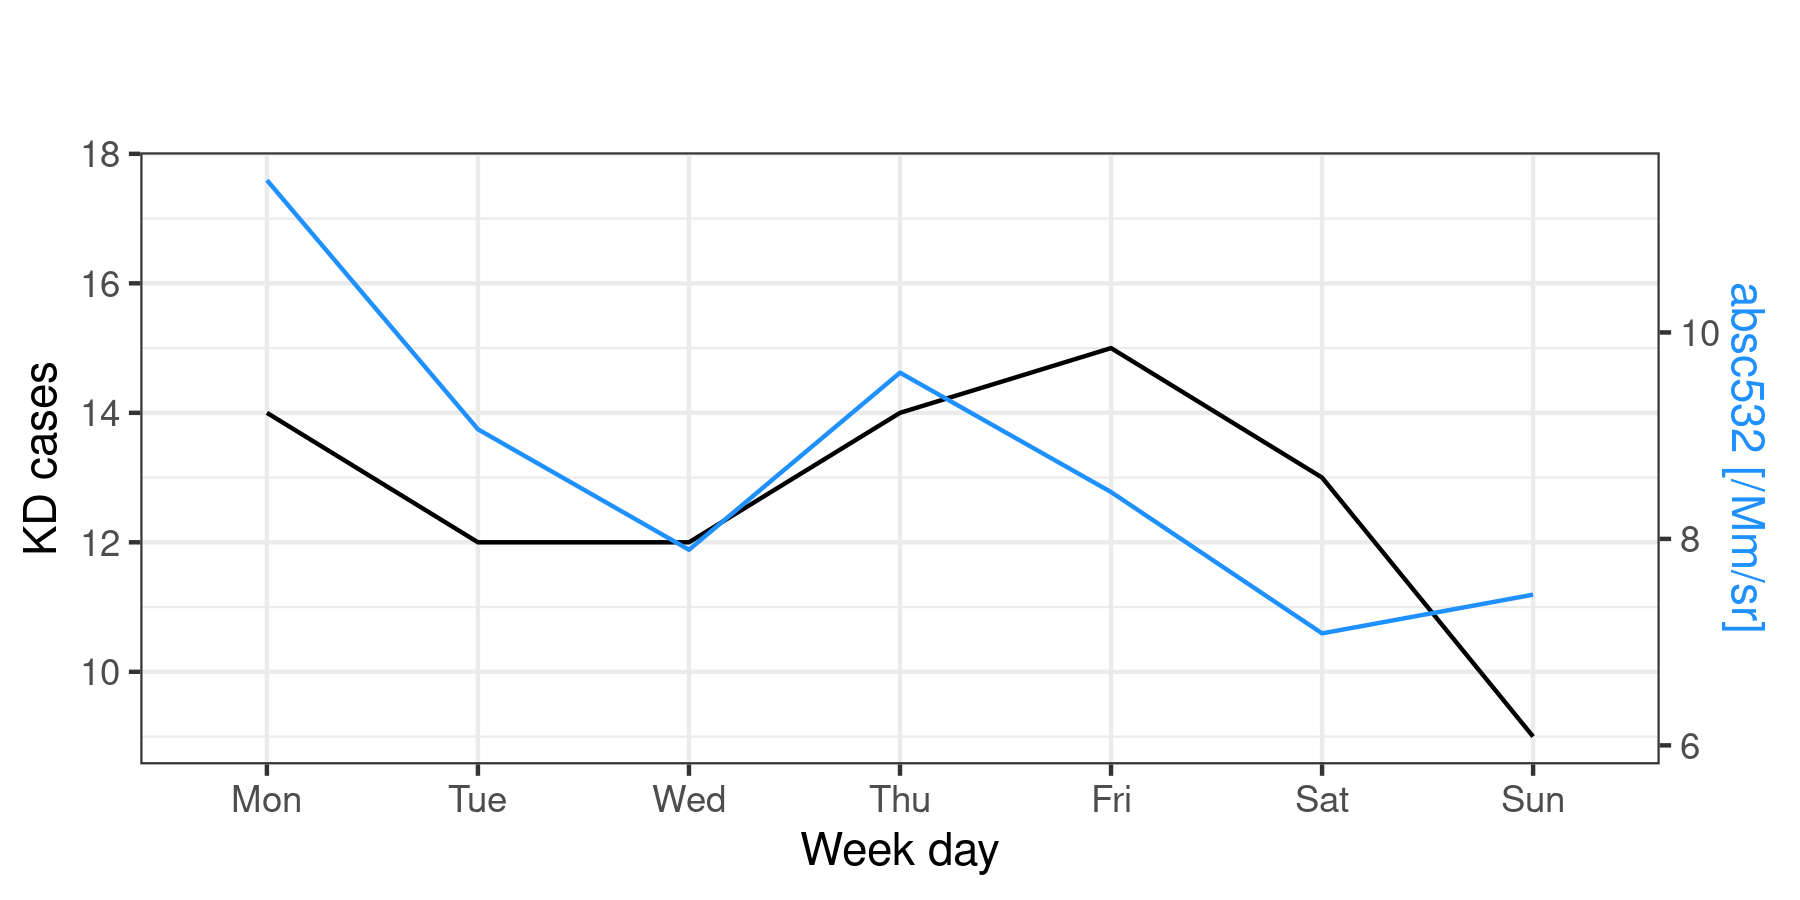

In [75]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res=300)
absc532_KD_Surf_6km <- readRDS("data/KD_absc532_mean_S-6km_daily.rds")

data_gg <- absc532_KD_Surf_6km %>%
    # Add a column with all the years from the time series daily index
    mutate(Year = year(Dates),
           Month = month(Dates)) %>%
    # Group by the month
    #group_by(Month = month(Dates), Year) %>%
    group_by(WeekDay = wday(Dates, week_start=1, label = TRUE)) %>%
    # Aggregate data monthly: mean, max or min?
    summarize_at(vars("absc532_TKO","KD_TKO"), list(~mean(.,na.rm = TRUE),
                                                   ~max(.,na.rm = TRUE),
                                                   ~min(.,na.rm = TRUE)))


max_ld <- max(data_gg$KD_TKO_max)+1
min_ld <- min(data_gg$KD_TKO_max)
max_kd <- max(data_gg$absc532_TKO_max)*1E+6 - 1
min_kd <- min(data_gg$absc532_TKO_max)*1E+6 - 1

# plot coefficient
ggCoeff_weekly <- (max_kd-min_kd)/(max_ld-min_ld)
intercept <- max_kd - (max_ld*ggCoeff_weekly)

ggplot(data_gg) +
    aes(x=WeekDay) +
    geom_line(aes(y= KD_TKO_max), group=1) +
    geom_line( aes(y= (absc532_TKO_max*1E+6 - intercept)/ggCoeff_weekly), color="dodgerblue", group=1) +
    scale_y_continuous(sec.axis = sec_axis(trans=~.*ggCoeff_weekly + intercept, #trans_sec , #* ggCoeff_weekly,
                                           name="absc532 [/Mm/sr]")) +
    theme_bw() + 
    labs(x='Week day',
         y='KD cases',
         title='',
         subtitle=paste('',sep='\n'),
         color='Variable') + 
    theme(plot.subtitle = element_text(color = "#605e5e", size = 9),
          plot.title = element_text(size=12),
          axis.title.y.right = element_text(color = "dodgerblue"),
          legend.position="bottom")

## Figure 5

### Figure 5A

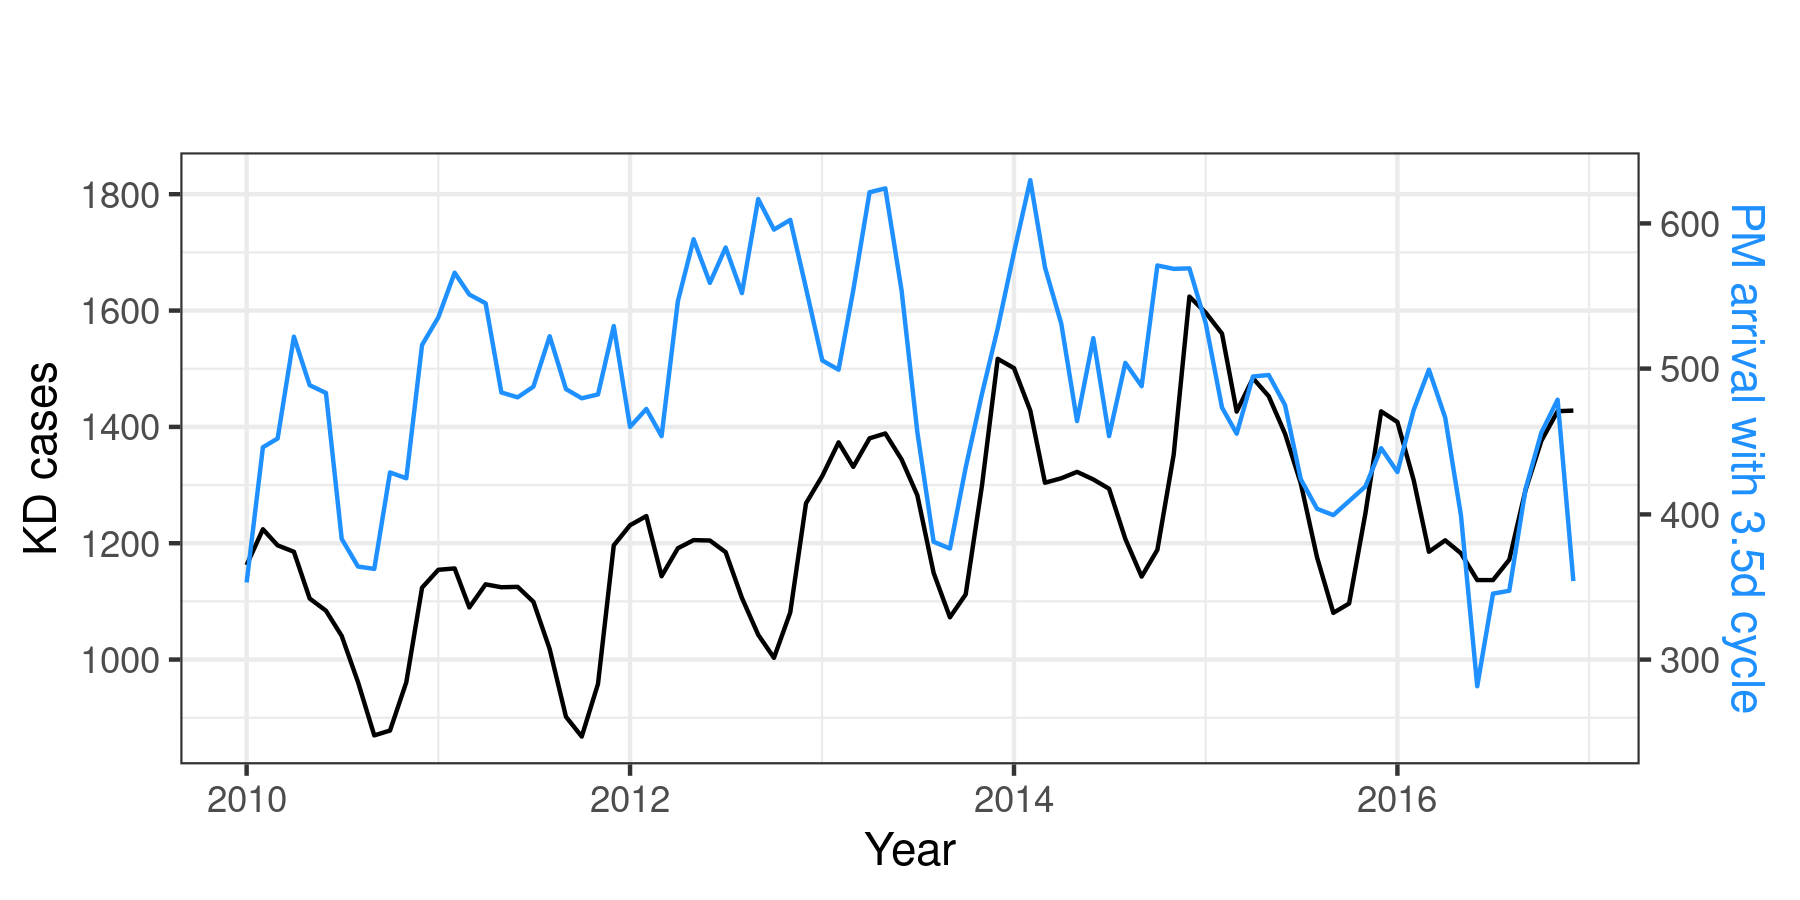

In [38]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res=300)
Corr_tb_TKO_m <- tibble(Corr =  Corr_tw84_c[[2]],
                        Dates = as.Date( names( Corr_tw84_c[[2]]) ) ) %>%
                 # Select correlations over 0.5
                 #filter(Corr >= 0.45 ) %>%
                 filter(Corr >= 0 ) %>%
                 group_by(Months=floor_date(Dates, "month")) %>%
                 summarise(absc532Corr=sum(!is.na(Corr)))%>%
                 mutate(absc532Corr = runmean(x = absc532Corr, k = 3 , alg = "C", endrule = "mean",align = "center"))
                 #summarise(absc532Corr=mean(Corr, na.rm=TRUE))
KD_file_m <- read_csv("../data/KD_1970_2016_Albert.csv", col_types = cols(.default = "c")) %>%
             mutate(Dates=as.Date(Dates)) %>%
             mutate(Japan = as.numeric(Japan)) %>%
             .[.$Dates %in% seq(as.Date("2010-01-01"),as.Date("2016-12-31"),by="day"),] %>%
             group_by(Months=floor_date(Dates, "month")) %>%
             summarise(KDcases=sum(Japan, na.rm=TRUE)) %>%
             mutate(KDcases = runmean(x = KDcases, k = 3 , alg = "C", endrule = "mean",align = "center"))

KD_2010_16_gg <- right_join(Corr_tb_TKO_m, KD_file_m,by = "Months")

ggKDCorrCoeff_m <- 2/5 #16/130
ggKDCorrInter_m <- -100 #-1120/13
ggplot(KD_2010_16_gg) +
    aes(x=Months) +
    geom_line(aes(y= KDcases), group=1) +
    geom_line( aes(y= (absc532Corr-ggKDCorrInter_m)/ggKDCorrCoeff_m, color="dodgerblue", group=1), 
              color="dodgerblue") +
    scale_y_continuous(sec.axis = sec_axis(trans=~.*ggKDCorrCoeff_m+ ggKDCorrInter_m, #trans_sec , #* ggCoeff_weekly,
                                           name="PM arrival with 3.5d cycle")) +
    theme_bw() + 
    labs(x='Year',
         y='KD cases',
         title='',
         subtitle=paste('',sep='\n'),
         color='Variable') + 
    theme(plot.subtitle = element_text(color = "#605e5e", size = 9),
          plot.title = element_text(size=12),
          axis.title.y.right = element_text(color = "dodgerblue"),
          legend.position="none"
          )

### Figure 5B

Don't know how to automatically pick scale for object of type table. Defaulting to continuous.



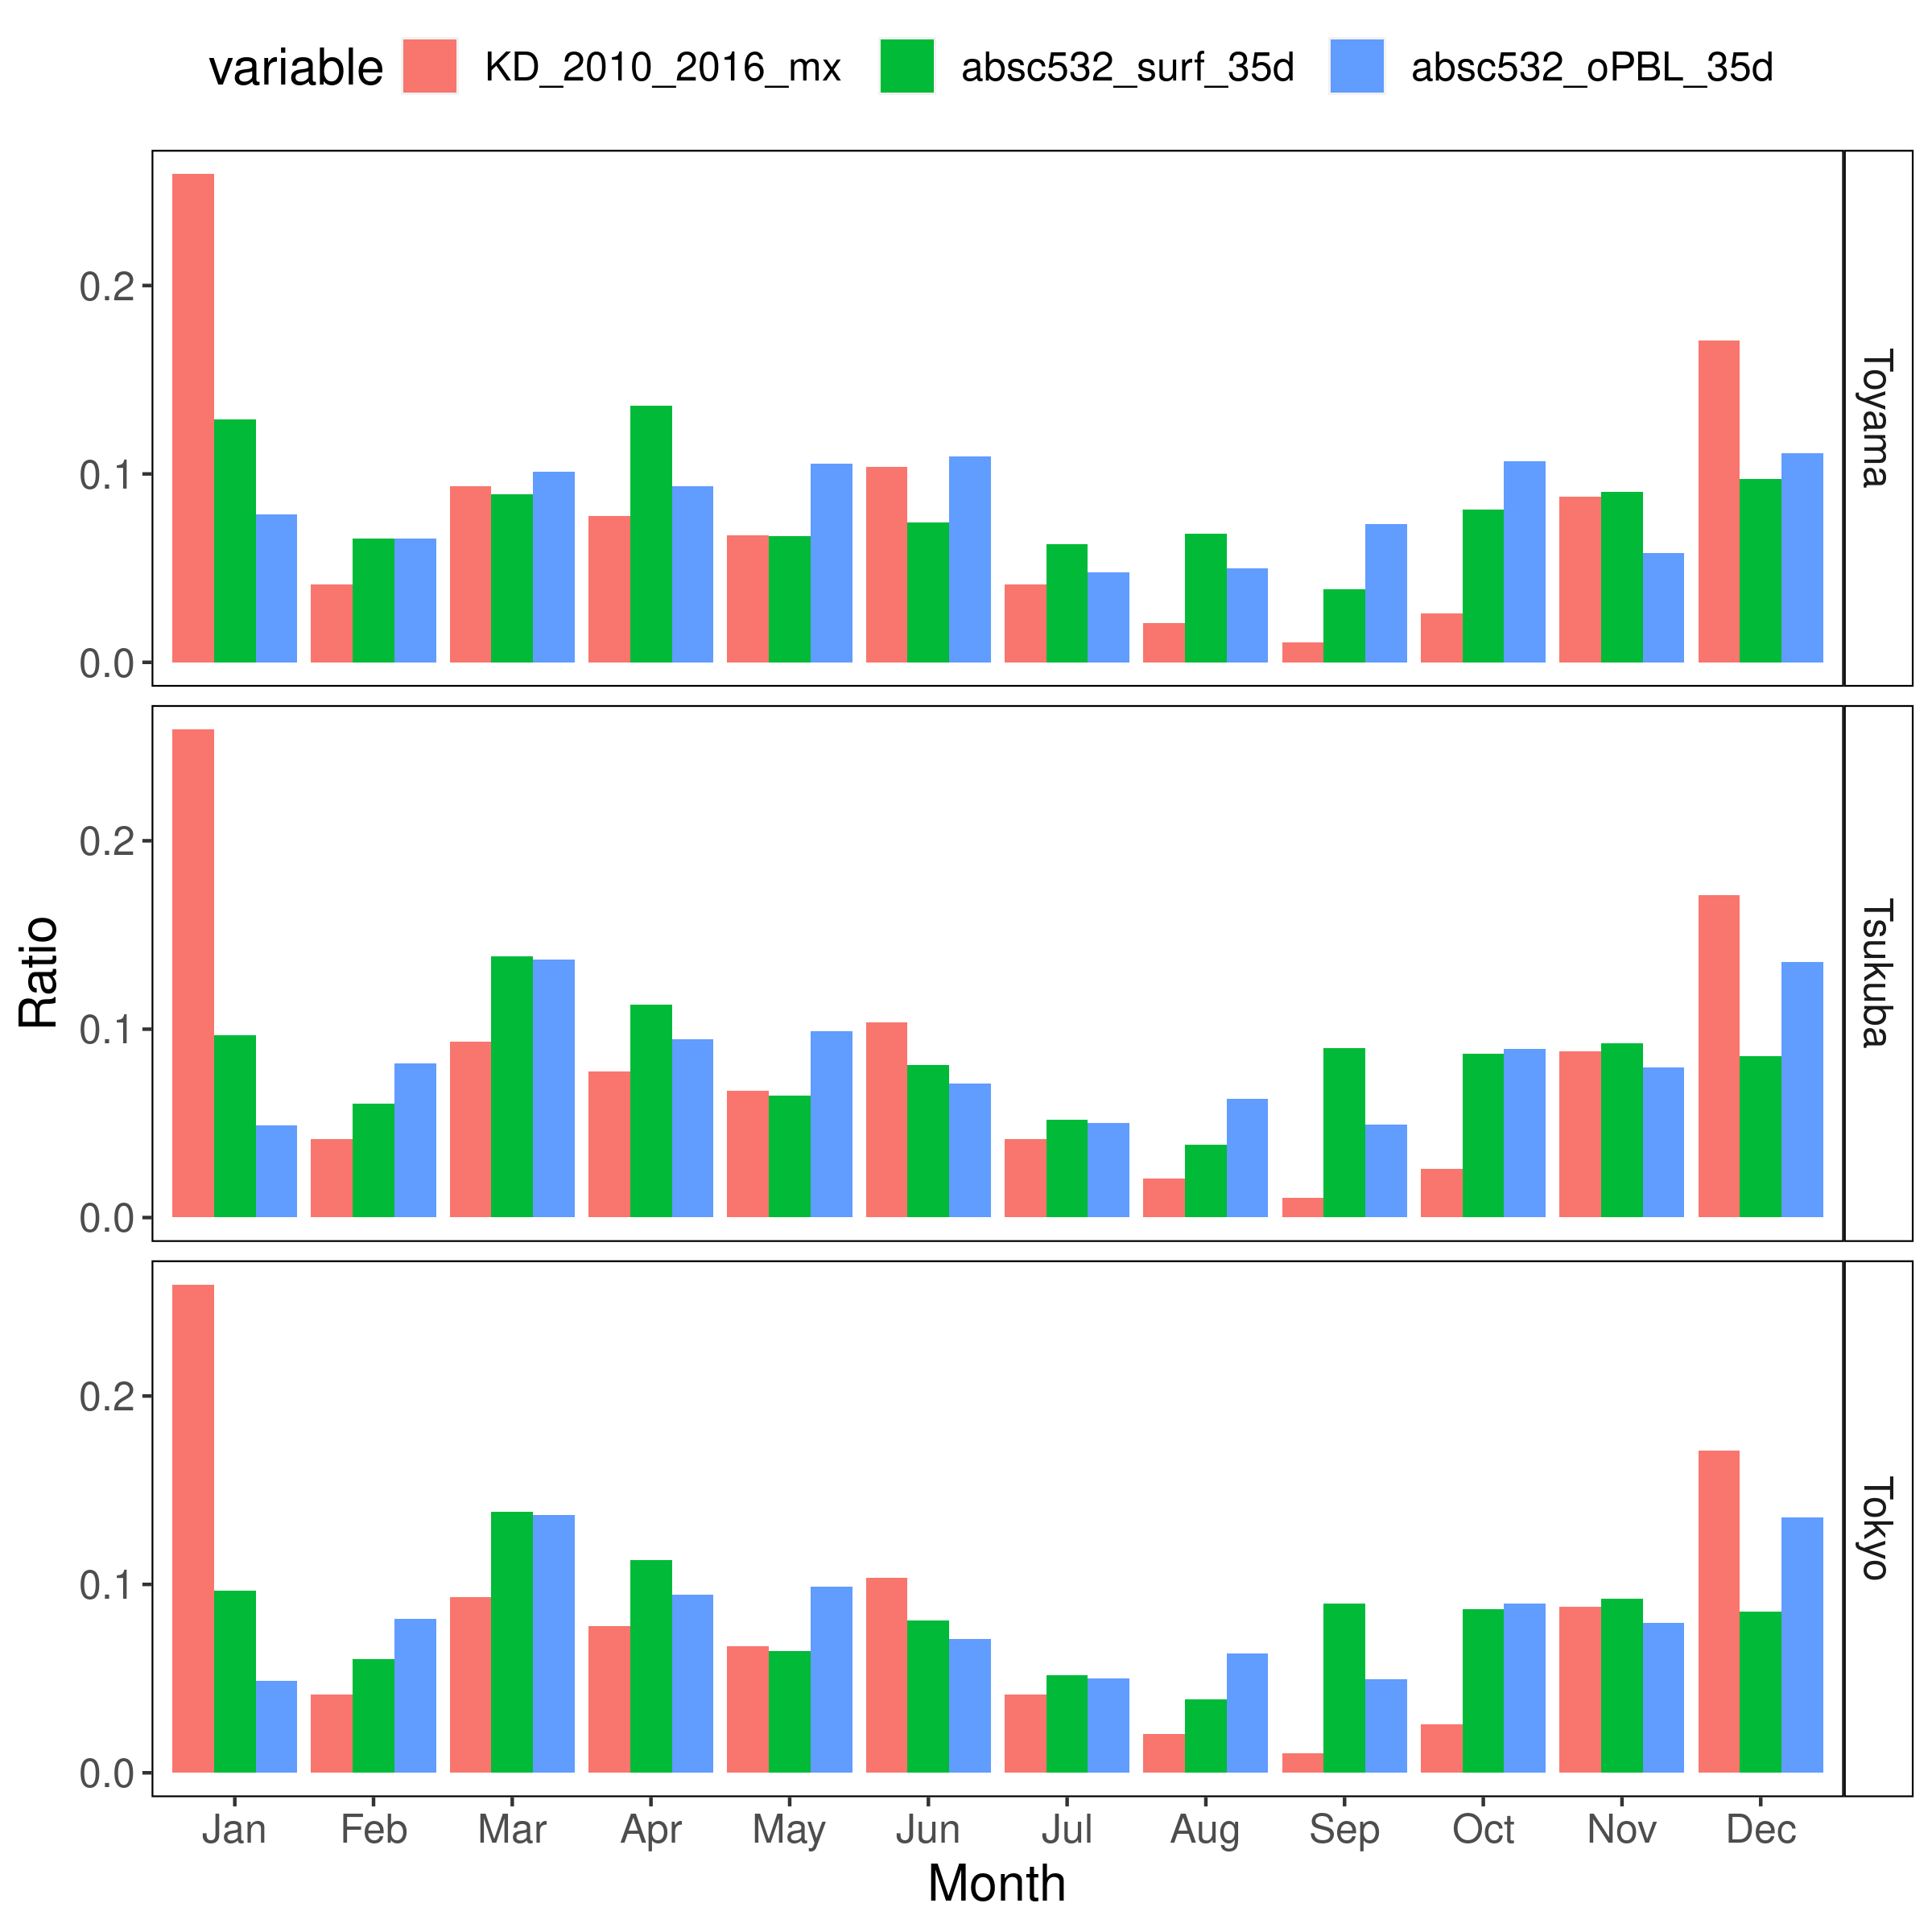

In [56]:
options(repr.plot.width = 8, repr.plot.height = 8, repr.plot.res=300)
library(IRdisplay)
Dates_gen <- function(d){
                      st_d <- d %>% as.character() %>% paste0("-01-01")
                      end_d <- (d+1) %>% as.character() %>% paste0("-01-01")
                      sq_d <- seq.Date(from = as.Date(st_d),to =as.Date(end_d),by="days") %>% head(-1)
                      return(sq_d)
}

Dates_KD <- lapply(seq(2011,2016,1),Dates_gen)
KD_list <- lapply(Dates_KD, function(k){ KD_file[KD_file$Dates %in% k,] %>%   #select 1 year period
                                     select(c("Japan")) %>% #select KD cases for all Japan
                                     mutate_all(as.numeric) %>% #transform to numeric
                                     t() %>% as.vector() %>% {'names<-'(., k) } #name values with dates
                                   })
KD_file <- read_csv("../data/KD_1970_2016_Albert.csv", col_types = cols(.default = "c")) %>%
     mutate(Dates=as.Date(Dates))
KD_list <- lapply(Dates_KD, function(k){ KD_file[KD_file$Dates %in% k,] %>%   #select 1 year period
                                 select(c("Japan")) %>% #select KD cases for all Japan
                                 mutate_all(as.numeric) %>% #transform to numeric
                                 t() %>% as.vector() %>% {'names<-'(., k) } #name values with dates
                               })
KD_maxima <- lapply(KD_list,function(a){  a[ a >= emp.hpd(a,conf = 0.90)[2] ]  }) %>% unlist() 
KD_2010_2016_mx <- names(KD_maxima) %>% as.Date() %>% 
                .[. %in% seq(as.Date("2010-01-01"),as.Date("2016-12-31"),by="day")] %>%
                month() %>% cut(seq(0,12,1)) %>% table()
Corr_pref <- readRDS("data/Corr84_OW")
jp_pref <- c("Toyama","Tsukuba","Tokyo")
datalist <- list()
for (i in seq_along(jp_pref)) {
    Corr_surf <- lapply(Corr_pref, `[[`, i) %>%
             lapply(., `[[`, 1) %>% unlist() %>%
             .[which(. >= 0.5)] %>% 
             #Extract dates
             names() %>% as.Date() %>%
             month() %>% cut(seq(0,12,1)) %>% table()

    Corr_oPBL <- lapply(Corr_pref, `[[`, i) %>%
             lapply(., `[[`, 2) %>% unlist() %>%
             .[which(. >= 0.5)] %>% 
             #Extract dates
             names() %>% as.Date() %>%
             month() %>% cut(seq(0,12,1)) %>% table()
#Divide the values between the years analized to get the year taxa
    Corr_KD_absc532 <- tibble(KD_2010_2016_mx = KD_2010_2016_mx/sum(KD_2010_2016_mx),
                         absc532_surf_35d = Corr_surf/sum(Corr_surf),
                         absc532_oPBL_35d = Corr_oPBL/sum(Corr_oPBL),
                         Month = factor(1:12, labels = c("Jan", "Feb", "Mar", "Apr",
                                                        "May", "Jun", "Jul", "Aug",
                                                        "Sep", "Oct", "Nov", "Dec"),
                                       ordered = TRUE) )   %>% 
                    pivot_longer(
                        cols = c("KD_2010_2016_mx", "absc532_surf_35d", "absc532_oPBL_35d"),
                        values_to = "value",
                        names_to = "variable",
                        names_repair = "minimal") %>%
                    mutate(station=jp_pref[i])
     datalist[[i]] <- Corr_KD_absc532   
}
Corr_KD_absc532 <- do.call(rbind, datalist)
Corr_KD_absc532$variable <- factor( Corr_KD_absc532$variable, 
    levels = c("KD_2010_2016_mx", "absc532_surf_35d", "absc532_oPBL_35d"))
Corr_KD_absc532$station <- factor( Corr_KD_absc532$station, 
levels = c("Toyama","Tsukuba","Tokyo"))

ggplot(Corr_KD_absc532, aes(x=Month, y=value, fill = variable, group = variable),position = "fill") +   
  geom_bar(position = "dodge", stat="identity") +
  ylab("Ratio") + 
  theme(
    text = element_text(size=15),
    panel.background = element_blank(),
    panel.border = element_rect(colour="black", fill=NA),
    plot.subtitle = element_text(color = "#605e5e", size = 9),
    plot.title = element_text(size=12),
    legend.position="top",
    strip.background = element_rect(color = "black",fill="white")
  ) +
  facet_grid(station~.)



## Figure 6

[1] 2010 2011 2012 2013 2014 2015 2016

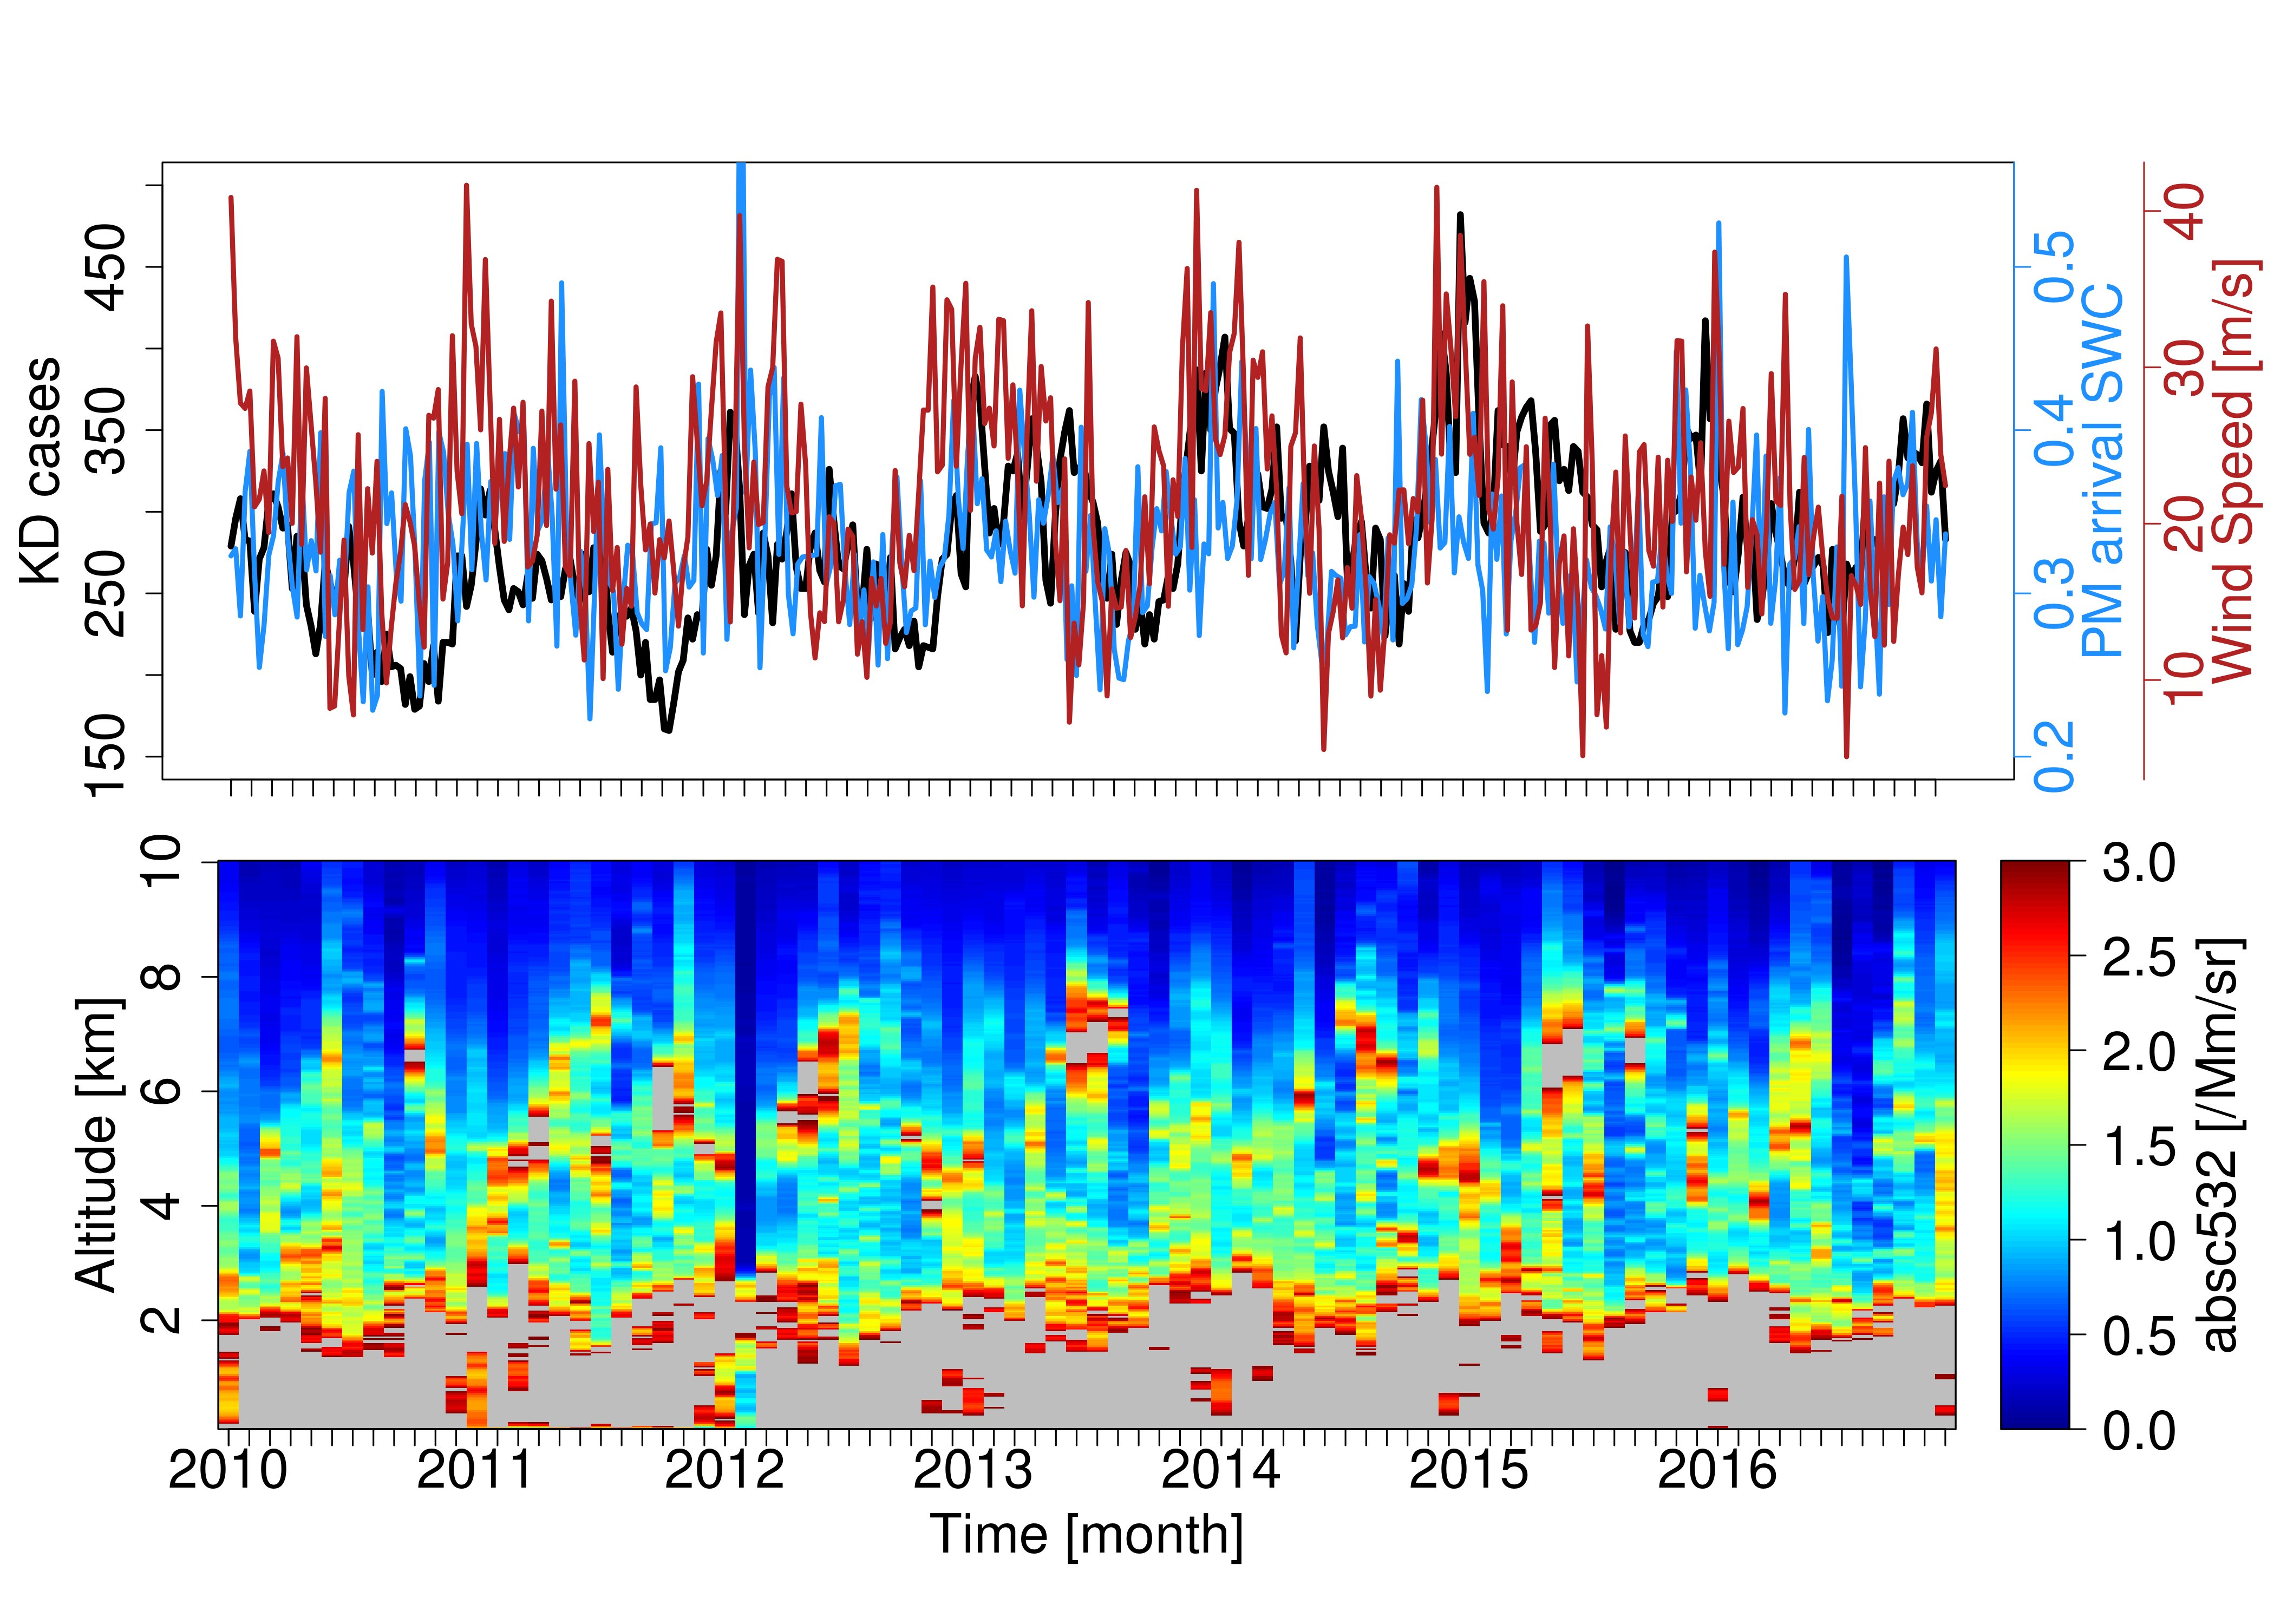

In [30]:
options(repr.plot.width = 14, repr.plot.height = 10, repr.plot.res=300)
# KD data daily -> weekly
KD_file_w <- read_csv("../data/KD_1970_2016_Albert.csv", col_types = cols(.default = "c")) %>%
             mutate(Dates=as.Date(Dates)) %>%
             # first week starts on the 3rd of January for 2010
             .[.$Dates %in% seq(as.Date("2010-01-03"),as.Date("2016-12-31"),by="day"),] %>%
             mutate(Japan = as.numeric(Japan)) %>%
             group_by(Months=floor_date(Dates, "week")) %>%
             summarise(KDcases=sum(Japan))
# head(KD_file)         
# Wind Spedd daily -> weekly
Uwind <- read.table("data/uwnd_YEAR1.1970_YEAR2.2016_LON.138.75_LAT.37.1422.txt", header = FALSE)
Vwind <- read.table("data/vwnd_YEAR1.1970_YEAR2.2016_LON.138.75_LAT.37.1422.txt", header = FALSE)
WSwind_w <- tibble( ws = sqrt( (Uwind$V4)^2 + (Vwind$V4)^2 ),
                    Dates = as.Date( paste(Uwind$V3,Uwind$V2,Uwind$V1,sep="-") ) ) %>%
            .[.$Dates %in% seq(as.Date("2010-01-03"),as.Date("2016-12-31"),by="day"),] %>%
            group_by(Month=floor_date(Dates, "week")) %>%
            summarise(SumWs=sum(ws,na.rm=TRUE))

#PM arrival with 3.5 days cycle
Jap_lidar <- c("TKB","TKO","TYM","SEO")

#Dates with 84d cycle
Corr_tw84 <- readRDS("data/Corr_tw84")
Corr_tw84_c <- lapply(seq_along(Jap_lidar), function(pref){
  Corr_tw84 %>%
    #First lvl of stations
    lapply( ., '[[', pref) %>%
    unlist() %>%
     # Remove extreme correlations
    ifelse(.==1,NA,.) %>%
    ifelse(.==-1,NA,.)
})
names(Corr_tw84_c) <- Jap_lidar
Corr_tb_TKO_w <- tibble(Corr =  Corr_tw84_c[[2]],
                        Dates = as.Date( names( Corr_tw84_c[[2]]) ) ) %>%
                 group_by(Months=floor_date(Dates, "week")) %>%
                 summarise(SumCorr=mean(Corr,na.rm = TRUE)) %>% na.omit()

# Plot x axis names
dts <- seq(2010,2016,1) #Study period [years]
m.names <- as.vector( outer(month.abb, str_sub(dts,start = 3) , paste0) ) #Names for months+year
#Plot
#Add extra space to right margin of plot within frame
par(mfrow=c(2,1)) 
par(mar=c(0, 4, 4, 7) + 1)

#1.KD cases Japan (Y1)
plot(KD_file_w$KDcases,type="l",xaxt="n", ylim=c(150,500), cex.axis=2, cex.lab=2,
     lwd=4,col="black", ylab="KD cases",xlab="", #ylim=c(-2.5,3.5),
     #main="Association of Japan KD cases with PM arrival in Tokyo per week (2010-2016)"
     )
axis(1,at=seq(1,length(WSwind_w$SumWs),4.36),labels=FALSE,las=2,cex.axis=2)

#2.PM arrival with 3.5days cycle (Y2)
par(new = TRUE)
plot(Corr_tb_TKO_w$SumCorr,type = "l", axes = FALSE, ylim = c(0.2,0.55),
     bty = "n", xlab = "", ylab = "",col="dodgerblue",lwd=3)
axis(4,at=pretty(range(Corr_tb_TKO_w$SumCorr)), cex.axis=2,
     col="dodgerblue",col.ticks ="dodgerblue",col.axis = "dodgerblue" )
mtext("PM arrival SWC", side=4, line=2.5,col="dodgerblue",cex=2)

#3.WindSpeed
par(new = TRUE)
plot(WSwind_w$SumWs,type = "l", axes = FALSE, cex.axis=2, cex.lab=2,
     bty = "n", xlab = "", ylab = "",col="firebrick",lwd=3)
axis(4,at=pretty(range(WSwind_w$SumWs)), line=4, cex.axis=2,
     col="firebrick",col.ticks ="firebrick",col.axis = "firebrick")
mtext("Wind Speed [m/s]", side=4, line=6.5,col="firebrick",cex=2)

absc532_mtx <- readRDS("data/absc532_TKO_MonthlyProfile.RDS")
height_a <-readRDS("data/absc532_TKO_Altitude.RDS")

#Select altitude
h120 <- which.min(abs(height_a-0.12)) #due to lidar resolution above 120m
h10000 <- which.min(abs(height_a-10)) #10km as maxima
h120_10000 <- seq(from=h120,to=h10000,by=1)

absc532_mtx_a <- absc532_mtx[,h120_10000]

#Names for months+year
#m.names <- as.vector( outer(month.abb, str_sub(dts,start = 3) , paste0) ) 
plotMonths <- seq(2010,2016,1)
plotMonths
par(mar=c(3, 2.2, 0, 1) + 1)
image2D(z = absc532_mtx_a*1E+06,
        clim = c(0,3),
        y = height_a[h120_10000],
        xlab="",xaxt="n", cex.axis = 2, cex.lab = 2, font=2,
        ylab="Altitude [km]",NAcol = "grey",
        colkey = list(cex.axis=2)
        #main="Lidar Tokyo mean absc532 per month (2010-2016)"
)
axis(1,seq(0,1,length.out = 84),labels = FALSE,las=2, line = -2)
axis(1,seq(0,1,length.out = 84)[seq(1,84,12)],
     labels = plotMonths,#[seq(1,84,4)],
     cex.axis = 2 , las=1, line = -2)
mtext("absc532 [/Mm/sr]", side=4, line=0,cex = 2)
mtext("Time [month]", side=1, line=1,cex = 2)

## Supplementary Figure 4

  |======================================================================| 100%

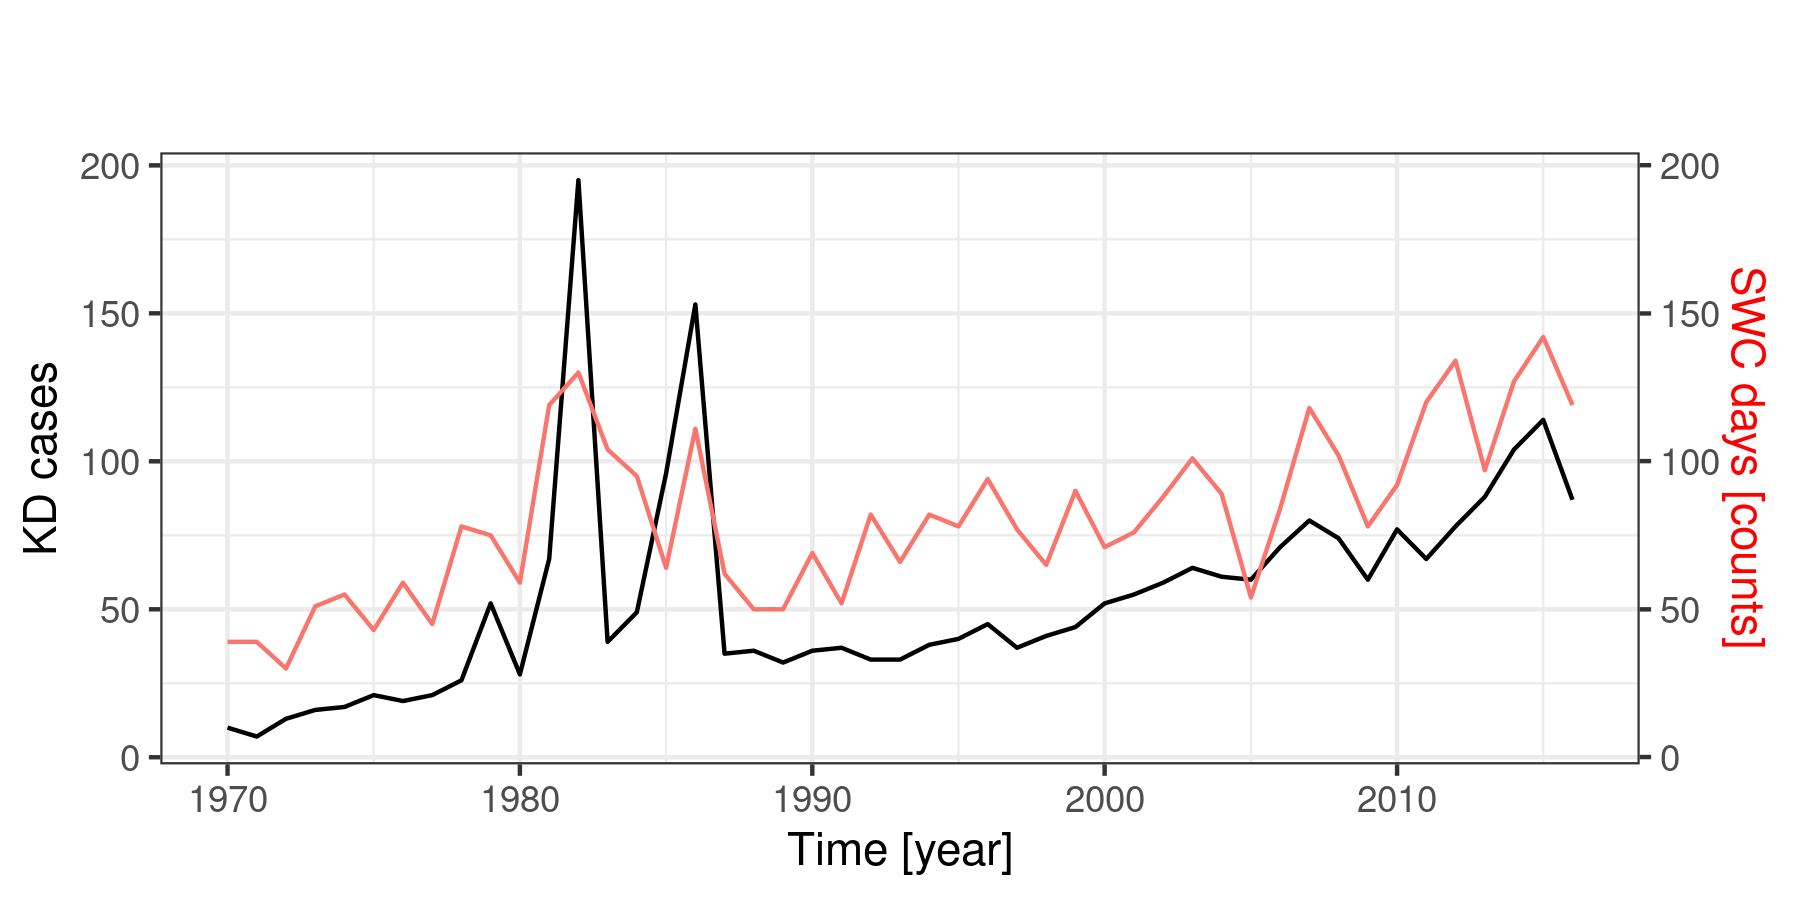

In [31]:
options(repr.plot.width = 6, repr.plot.height = 3, repr.plot.res=300)
# KD data daily -> yearly
KD_file_y <- read_csv("../data/KD_1970_2016_Albert.csv", col_types = cols(.default = "c")) %>%
             mutate(Dates=as.Date(Dates)) %>%
             mutate(Japan = as.numeric(Japan)) %>%
             group_by(Months=floor_date(Dates, "year")) %>%
             summarise(KDcases=max(Japan,na.rm=TRUE))

# Compute OW-SDC for KD daily data at s=7 and lag=7d+-1d
KD_file_d <- read_csv("../data/KD_1970_2016_Albert.csv", col_types = cols(.default = "c")) %>%
             mutate(Dates=as.Date(Dates)) %>%
             mutate(Japan = as.numeric(Japan)) #%>%
             #.[.$Dates %in% seq(as.Date("2010-01-01"),as.Date("2010-03-31"),by="day"),]

# Empty list for correlation values
Corr_pref7 <- list()

# Dates list
Dates_00 <- list(
seq.Date(from = as.Date("1970-01-01"),to = as.Date("1971-01-14"),by="days"),
seq.Date(from = as.Date("1970-12-25"),to = as.Date("1972-01-14"),by="days"),
seq.Date(from = as.Date("1971-12-25"),to = as.Date("1973-01-14"),by="days"),
seq.Date(from = as.Date("1972-12-25"),to = as.Date("1974-01-14"),by="days"),
seq.Date(from = as.Date("1973-12-25"),to = as.Date("1975-01-14"),by="days"),
seq.Date(from = as.Date("1974-12-25"),to = as.Date("1976-01-14"),by="days"),
seq.Date(from = as.Date("1975-12-25"),to = as.Date("1977-01-14"),by="days"),
seq.Date(from = as.Date("1976-12-25"),to = as.Date("1978-01-14"),by="days"),
seq.Date(from = as.Date("1977-12-25"),to = as.Date("1979-01-14"),by="days"),
seq.Date(from = as.Date("1978-12-25"),to = as.Date("1980-01-14"),by="days"),
seq.Date(from = as.Date("1979-12-25"),to = as.Date("1981-01-14"),by="days"),
seq.Date(from = as.Date("1980-12-25"),to = as.Date("1982-01-14"),by="days"),
seq.Date(from = as.Date("1981-12-25"),to = as.Date("1983-01-14"),by="days"),
seq.Date(from = as.Date("1982-12-25"),to = as.Date("1984-01-14"),by="days"),
seq.Date(from = as.Date("1983-12-25"),to = as.Date("1985-01-14"),by="days"),
seq.Date(from = as.Date("1984-12-25"),to = as.Date("1986-01-14"),by="days"),
seq.Date(from = as.Date("1985-12-25"),to = as.Date("1987-01-14"),by="days"),
seq.Date(from = as.Date("1986-12-25"),to = as.Date("1988-01-14"),by="days"),
seq.Date(from = as.Date("1987-12-25"),to = as.Date("1989-01-14"),by="days"),
seq.Date(from = as.Date("1988-12-25"),to = as.Date("1990-01-14"),by="days"),
seq.Date(from = as.Date("1989-12-25"),to = as.Date("1991-01-14"),by="days"),
seq.Date(from = as.Date("1990-12-25"),to = as.Date("1992-01-14"),by="days"),
seq.Date(from = as.Date("1991-12-25"),to = as.Date("1993-01-14"),by="days"),
seq.Date(from = as.Date("1992-12-25"),to = as.Date("1994-01-14"),by="days"),
seq.Date(from = as.Date("1993-12-25"),to = as.Date("1995-01-14"),by="days"),
seq.Date(from = as.Date("1994-12-25"),to = as.Date("1996-01-14"),by="days"),
seq.Date(from = as.Date("1995-12-25"),to = as.Date("1997-01-14"),by="days"),
seq.Date(from = as.Date("1996-12-25"),to = as.Date("1998-01-14"),by="days"),
seq.Date(from = as.Date("1997-12-25"),to = as.Date("1999-01-14"),by="days"),
seq.Date(from = as.Date("1998-12-25"),to = as.Date("2000-01-14"),by="days"),
seq.Date(from = as.Date("1999-12-25"),to = as.Date("2001-01-14"),by="days"),
seq.Date(from = as.Date("2000-12-25"),to = as.Date("2002-01-14"),by="days"),
seq.Date(from = as.Date("2001-12-25"),to = as.Date("2003-01-14"),by="days"),
seq.Date(from = as.Date("2002-12-25"),to = as.Date("2004-01-14"),by="days"),
seq.Date(from = as.Date("2003-12-25"),to = as.Date("2005-01-14"),by="days"),
seq.Date(from = as.Date("2004-12-25"),to = as.Date("2006-01-14"),by="days"),
seq.Date(from = as.Date("2005-12-25"),to = as.Date("2007-01-14"),by="days"),
seq.Date(from = as.Date("2006-12-25"),to = as.Date("2008-01-14"),by="days"),
seq.Date(from = as.Date("2007-12-25"),to = as.Date("2009-01-14"),by="days"),
seq.Date(from = as.Date("2008-12-25"),to = as.Date("2010-01-14"),by="days"),
seq.Date(from = as.Date("2009-12-25"),to = as.Date("2011-01-14"),by="days"),
seq.Date(from = as.Date("2010-12-25"),to = as.Date("2012-01-14"),by="days"),
seq.Date(from = as.Date("2011-12-25"),to = as.Date("2013-01-14"),by="days"),
seq.Date(from = as.Date("2012-12-25"),to = as.Date("2014-01-14"),by="days"),
seq.Date(from = as.Date("2013-12-25"),to = as.Date("2015-01-14"),by="days"),
seq.Date(from = as.Date("2014-12-25"),to = as.Date("2016-01-14"),by="days"),
seq.Date(from = as.Date("2015-12-25"),to = as.Date("2016-12-31"),by="days")
)
#Progress bar
pb <- txtProgressBar(min = 0, max = length(Dates_00), initial = 0,style=3) 

for(dd in seq_along(Dates_00)){
    Dates_0 <- Dates_00[[dd]]

    ##########
    #OW-SDC  #
    ##########
    # Timer series
    ts_lead <- KD_file_d %>% 
               .[.$Dates %in% Dates_0,] %>%
               select(Japan) %>% t() %>% as.vector
    ts_sub  <- KD_file_d %>% 
               .[.$Dates %in% Dates_0,] %>%
               select(Japan) %>% t() %>% as.vector
    #Window size
    sw <- 7
    #Lag from the main diagonal
    sl <- 7

    #Al possible windows of size sw
    k1 <- seq(from=1,to=length(ts_lead),by=1)
    k2 <- seq(from=1,to=length(ts_sub),by=1)

    ts_v1_wf <- sapply(k1,function(x){  ts_lead[x:(x+sw)] })
    ts_v2_wf <- sapply(k2,function(x){  ts_sub[x:(x+sw)] })

    #All values for real windows until first NA
    ts_v1_wf_cln <- ts_v1_wf[,1:(dim(ts_v1_wf)[2]-sw)]
    ts_v2_wf_cln <- ts_v2_wf[,1:(dim(ts_v2_wf)[2]-sw)]

    #Correlation matrix with respective p-value with spearman method
    cor.SDC <- rcorr(ts_v1_wf_cln,ts_v2_wf_cln, type = "spearman")
    cor.mtx <- cor.SDC$r[(dim(cor.SDC$r)[2]/2+1):dim(cor.SDC$r)[2],1:(dim(cor.SDC$r)[1]/2)]             
    cor.p.v <- cor.SDC$P[(dim(cor.SDC$P)[2]/2+1):dim(cor.SDC$P)[2],1:(dim(cor.SDC$P)[1]/2)]
    cor.SDC <- NULL #Clean memory
    cor.mtx[cor.p.v > 0.05] <- NA #Significance test applied

    # A companion matrix that indicates how "off" a diagonal is:
    delta <- row(cor.mtx) - col(cor.mtx)

    #Reverse matrix since image.plot() reverses the image (matrix values)  
    mat1 <- apply(cor.mtx, 2, rev)

    #Save cor.mtx dimensions and clean memory
    dim_cor <- dim(cor.mtx)
    cor.p.v <- NULL

    #Use split to group on these values
    diagonals <- split(cor.mtx, delta)
    cor.mtx <- NULL

    #Selected area for correlation analysis
    area_sel <- 1
    disc.line <- c((sl-area_sel):(sl+area_sel))
    area_diags <- lapply(disc.line,function(z){diagonals[[z + dim_cor[1]]] })
    diagonals <- NULL

    #Cut diagonals to have the same length
    #Dates has an extra length due to the selection of the lag
    #before and after the date (2*sl) and the extra due to SDC (sw)
    diag_len <- length(Dates_0) - sw - 2*sl

    cut_diags <- list()

    for (cc in seq_along(area_diags)) {
      #For off diagonals greater than the lag sl we insert NAs
      #at the beginning and cut for diag_len to remove the extra tail
      if((sl-disc.line[cc])<0){
        cut_diags[[cc]] <- c(rep(NA,abs(sl-disc.line[cc])),area_diags[[cc]])[1:diag_len]
      } else {
        #For off diagonals lesser than the lag sl we remove the first
        #positions and select accordingly to diag_len
        cut_diags[[cc]] <- area_diags[[cc]][seq(sl-disc.line[cc]+1,
                                                diag_len+sl-disc.line[cc],1)]
      }                                      

    }

    area_max_corr <-  do.call(cbind,cut_diags) %>% 
      #Substract main diagonal values equal to 1
      ifelse(.== 1,NA,.) %>%
      ifelse(.== -1,NA,.) %>%
      apply(.,1,function(invec){
        na.pct <- sum(is.na(invec))/length(invec)
        if (na.pct == 1) {
          return(NA) }
        else {
          # return(invec[which.max(abs(invec))])
          return(max(invec, na.rm=TRUE))
        }
      })

    startDateInd <- sl + 1
    finalDateInd <- length(Dates_0) - sw - sl

    KD_file_weeklyCycle <- tibble(Dates = Dates_0[startDateInd:finalDateInd],
                                  KD_corr = area_max_corr) 
    Corr_pref7[[dd]] <- KD_file_weeklyCycle
    setTxtProgressBar(pb,dd)
}    
    

KD_corr_y <- bind_rows(Corr_pref7) %>%
             filter(KD_corr > 0.5) %>%
             group_by(Months=floor_date(Dates, "year")) %>%
             summarise(KD_corr=sum(!is.na(KD_corr)))
KD_gg <- right_join(KD_corr_y,KD_file_y,by = "Months")
ggKDCorrCoeff <- 1 #(3/14)*1E-4
ggKDCorrInter <- 0 #23/35
ggplot(KD_gg) +
    aes(x=Months) +
    geom_line(aes(y= KDcases), group=1) +
    geom_line( aes(y= (KD_corr-ggKDCorrInter)/ggKDCorrCoeff, color="red", group=1)) +
    scale_y_continuous(sec.axis = sec_axis(trans=~.*ggKDCorrCoeff+ ggKDCorrInter, #trans_sec , #* ggCoeff_weekly,
                                           name="SWC days [counts]")) +
    theme_bw() + 
    labs(x='Time [year]',
         y='KD cases',
         title='',
         subtitle=paste('',sep='\n'),
         color='Variable') + 
    theme(plot.subtitle = element_text(color = "#605e5e", size = 9),
          plot.title = element_text(size=12),
          axis.title.y.right = element_text(color = "red"),
          legend.position="none"
          )

## Supplementary Figure 6

[1] "Number of KD maxima (0.95) for TKB: 162"
[1] "Number of PM entry days for TKB: 166"
[1] "Number of KD maxima (0.95) for TKO: 109"
[1] "Number of PM entry days for TKO: 165"
[1] "Number of KD maxima (0.95) for TYM: 243"
[1] "Number of PM entry days for TYM: 74"


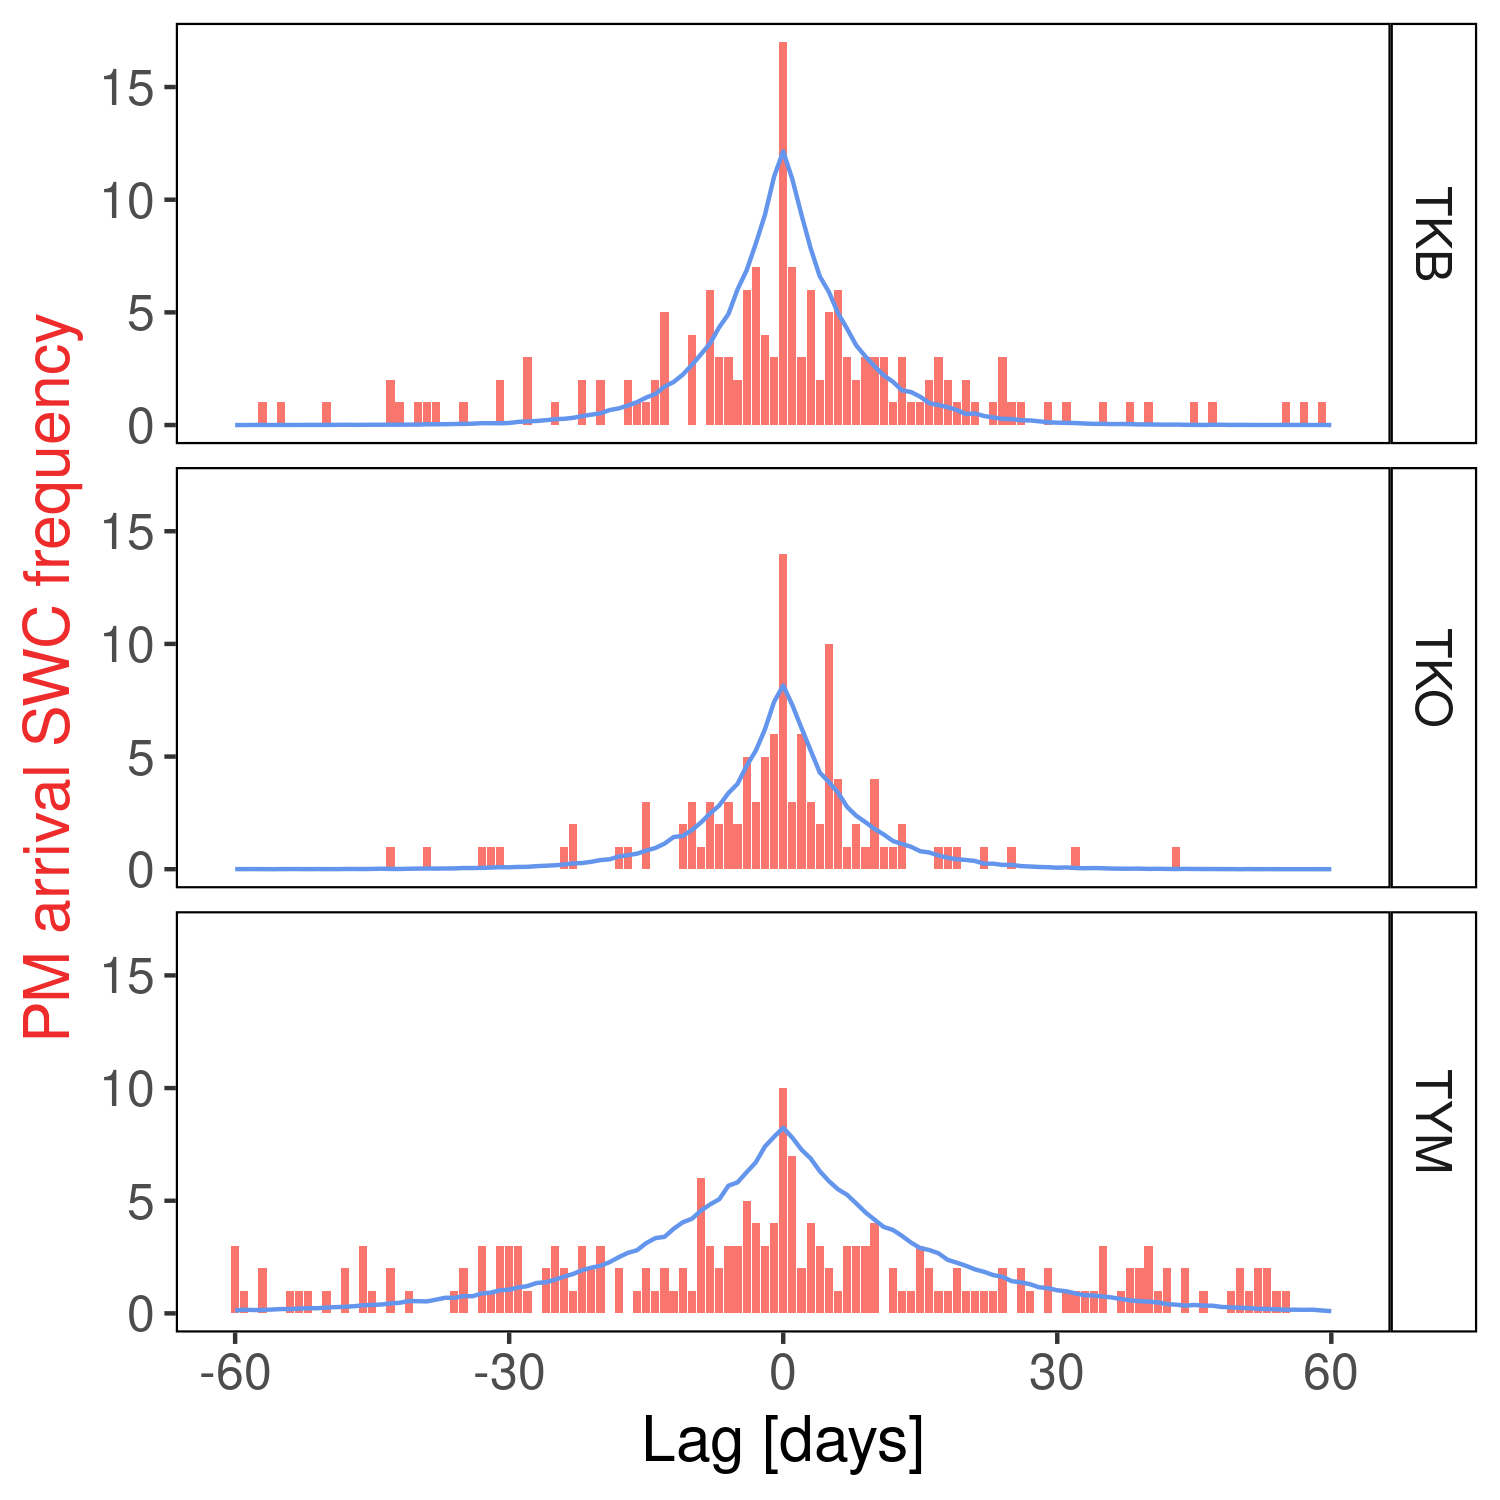

In [35]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=300, warn=-1)

AeroIntrDays <- tibble(DatesH = seq(from = as.POSIXct("2010-01-01 00:00:00",tz = "UTC"),
                                to = as.POSIXct("2016-12-31 23:00:00",tz = "UTC"),
                                by="hour"),
                   TKB = Corr_tw84_c[["TKB"]],
                   TKO = Corr_tw84_c[["TKO"]],
                   TYM = Corr_tw84_c[["TYM"]],
                ) %>%
                filter(as.Date(DatesH) >= as.Date("2011-01-01") ) %>%
                # Extract days with aerosol entries
                group_by(Dates = floor_date(DatesH, "day")) %>%
                summarize_at(vars("TKB","TKO","TYM"), list(~max(.,na.rm = TRUE))) %>%
                ungroup() %>%
                # Filter for correlations over 0.5
                mutate_at(vars(-("Dates")), function(x){replace(x, x < 0, NA)})

# KD data days
Dates_gen <- function(d){
  st_d <- d %>% as.character() %>% paste0("-01-01")
  end_d <- (d+1) %>% as.character() %>% paste0("-01-01")
  sq_d <- seq.Date(from = as.Date(st_d),to =as.Date(end_d),by="days") %>% head(-1)
  return(sq_d)
}
Dates_KD <- lapply(seq(2011,2016,1), Dates_gen)
# Import KD daily data
KD_fileDays <- KD_file_ms <- read_csv("../data/KD_1970_2016_Albert.csv", col_types = cols(.default = "c")) %>%
               mutate(Dates=as.Date(Dates)) %>%
               rename(c("TKB"="8", "TKO"="13", "TYM"="16")) %>%
               select(c(Dates,TKB,TKO,TYM)) %>%
               mutate(across(!Dates, as.numeric)) %>%
              .[.$Dates %in% seq(as.Date("2011-01-01"),as.Date("2016-12-31"),by="day"),]
# Keep correlations above this value
corrFilter <- 0.5
# Empty list to store data for plot
lag_KDAero_list <- list()
# LIDAR stations
jplidar <- c("TKB","TKO","TYM")
for (jp in jplidar){
#lapply computes a function for all the elements in the list
#operator %>% indicates a pipe, which tells R to take the value of that which is to the left and pass it to the right as an argument
#operatior %in% ensures matching conditions from a vector, in this case dates (Dates_KD)
KD_list <- lapply(Dates_KD, 
                  function(k){ 
                      KD_fileDays[KD_fileDays$Dates %in% k,] %>%   #select 1 year period
                      select(c(jp)) %>% #select KD cases for all prefecture
                      t() %>% as.vector() %>% {'names<-'(., k) } #name values with dates
        })
KDmax_Days <- lapply(KD_list,function(a){  a[ a >= emp.hpd(a,conf = 0.97)[2] ]  }) %>% 
              unlist() %>% names() %>% as.Date()
    
KDmax_Days_Test_A <- lapply(KD_list,function(a){  a[ a >= emp.hpd(a,conf = 0.95)[2] ]  }) %>% 
                       unlist() %>% table()
KDmax_Days_Test_B <- lapply(KD_list,function(a){  a[ a >= emp.hpd(a,conf = 0.97)[2] ]  }) %>% 
                       unlist() %>% table()
#print(KDmax_Days_Test_A)
#print(KDmax_Days_Test_B)
print(paste0("Number of KD maxima (0.95) for ",jp,": ", length(KDmax_Days)) )
AeroTKO_Days <- AeroIntrDays %>% select(c("Dates", jp)) %>% 
                mutate_at(vars(-("Dates")), function(x){replace(x, x < corrFilter, NA)}) %>% drop_na() %>% 
                select(Dates) %>% t() %>% as.vector() %>% as.Date()
print(paste0("Number of PM entry days for ",jp,": ", length(AeroTKO_Days)) )

#Lag between KD maxima and absc532 oPBL
diff_KD_Aero <- sapply(KDmax_Days, 
                       function(l){  #Differece between days
                         dft <- difftime(l,AeroTKO_Days,units = "days") 
                         #Selects first absolute minimum with the sign since
                         #in case of draw it select the first in order, the negative.
                         dft[which.min( abs( dft ) ) ]
                       })
    
#print(tibble(KDmax_dates = KDmax_Days, Lag = diff_KD_Aero) %>% filter(Lag == 5) )
# Random dates comparision    
rnd_list <- list()
for(rd in 1:1000){
rndDates <- sample(seq(as.Date("2011-01-01"), as.Date("2016-12-31"), by="day"), length(AeroTKO_Days))
#Lag between KD maxima and absc532 oPBL
diff_KD_Rnd <- sapply(KDmax_Days, 
                       function(l){  #Differece between days
                         dft <- difftime(l,rndDates,units = "days") 
                         #Selects first absolute minimum with the sign since
                         #in case of draw it selects the first in order, the negative.
                         dft[which.min( abs( dft ) ) ]
                       })
rnd_list[[rd]] <- table(factor(diff_KD_Rnd, levels=-60:60)) %>% 
                  t() %>% as.vector()
}

lag_KDAero_pref <- tibble( Real = table(factor(diff_KD_Aero, levels=-60:60)) ,
                           Days = names(Real),
                           Rnd = do.call(cbind, rnd_list) %>% rowMeans(., na.rm=TRUE),
                           Station = jp
                          )

lag_KDAero_list[[jp]] <- lag_KDAero_pref
}


# Bind KD into a single dataset
lag_KDAero <- bind_rows(lag_KDAero_list,.id = "BindVar") %>% select(-c(BindVar)) %>%
              melt(id.vars=c("Days","Station"))

#head(lag_KDAero)

dailyLag_gg <- ggplot(lag_KDAero, 
       aes(x=as.numeric(Days), y=value, fill=variable)) +  
  #geom_histogram(alpha=0.6, position="identity",binwidth = 1) + 
  #scale_colour_manual(values=c(Lag="limegreen"))+
 geom_bar(data=subset(lag_KDAero,variable == "Real"), stat="identity",position="identity") +
 geom_line(data=subset(lag_KDAero,variable == "Rnd"), colour="cornflowerblue") + 
 #geom_line(alpha=0.6) +

 labs(x="Lag [days]",
     y="PM arrival SWC frequency",
     color="Lag"#,
     #title='Lag between KD maxima (0.97) and PM entry days',
     #subtitle="Station: KDmax | PM entry days. TKB: 162 | 166. TKO: 109 | 165. TYM: 243 | 74"
     
     ) + 
  theme(
    text = element_text(size=15),
    panel.background = element_blank(),
    panel.border = element_rect(colour="black", fill=NA),
    plot.subtitle = element_text(color = "#605e5e", size = 9),
    plot.title = element_text(size=12),
    legend.position="none",
      axis.title.y.left = element_text(color = "firebrick2"),
    strip.background = element_rect(color = "black",fill="white")
  ) +
  facet_grid(Station~.)
dailyLag_gg 

## Supplementary Figure 7

### Supplementary Figure 7A

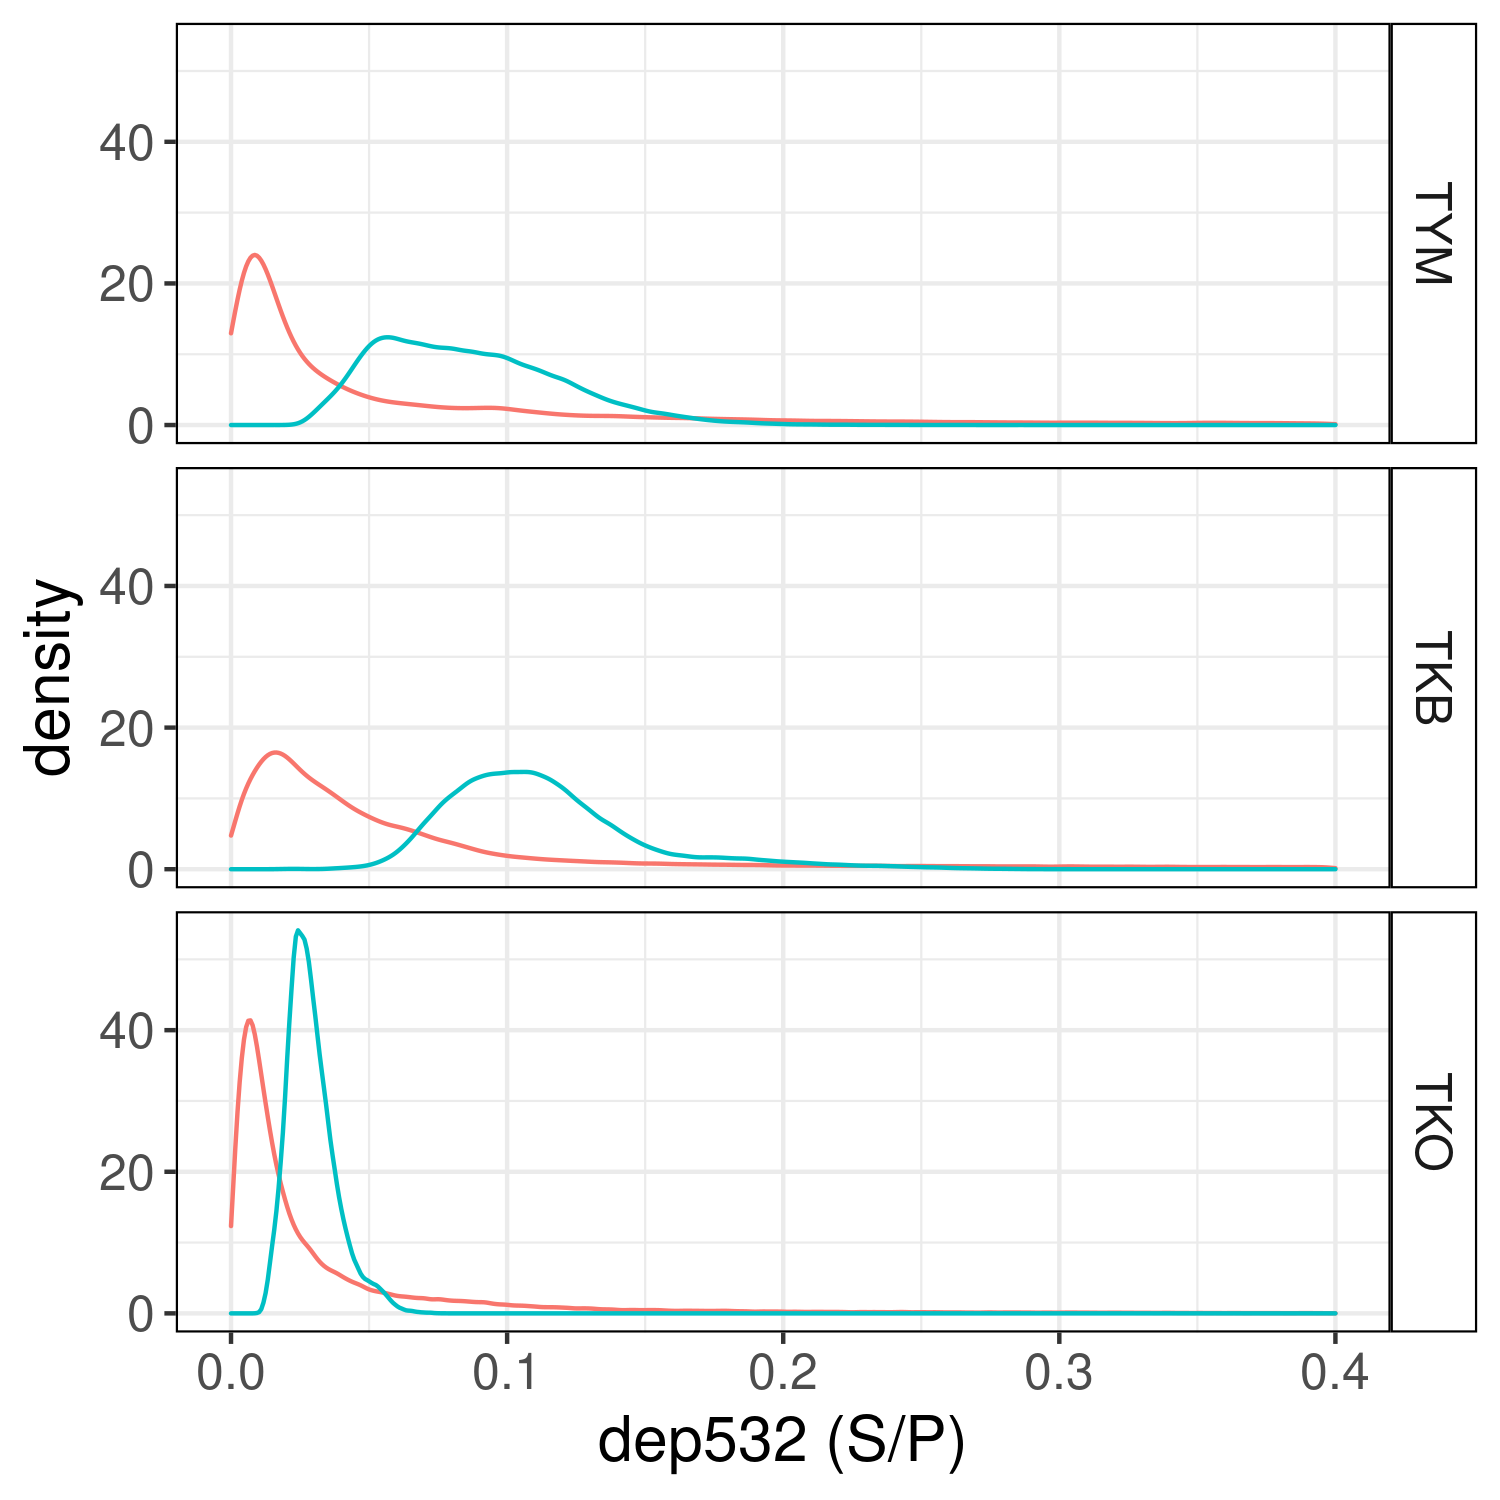

In [36]:
LidarStations_35d <- read_rds("data/LidarSatations_35d.RDS")
# 1.1 Select dates from TW between absc532 from 4.3-6km and surface with 3.5days cycle from hourly data.
# When does the cycle 3.5days reach the surface in a particle variable such as absc532?
Corr_tw84 <- readRDS("data/Corr_tw84")
# LIDAR stations
Jap_lidar <- c("TKB","TKO","TYM")
Corr_tw84_c <- lapply(seq_along(Jap_lidar), function(pref){
  Corr_tw84 %>%
    #First lvl of stations
    lapply( ., '[[', pref) %>%
    unlist() %>%
    ifelse(.==1,NA,.)
})
# Name list with station names
names(Corr_tw84_c) <- Jap_lidar
lidStat_List <- list()
lidStat_List_rnd <- list()
# Select specific altitude layers from absc532 vertical profile plot
altSlice_st <- list("TKB"=paste0("V",seq(67,100)),
                    "TKO"=paste0("V",seq(50,83)),
                    "TYM"=paste0("V",seq(100,133))
                    )
for(st in Jap_lidar){
  Corr_dates <- tibble(Corr =  Corr_tw84_c[[st]],
                       DatesH = seq(from = as.POSIXct("2010-01-01 00:00:00",tz = "UTC"),
                                    to = as.POSIXct("2016-12-31 23:00:00",tz = "UTC"),
                                    by="hour") )%>%
                # Select correlations over 0.5
                filter(Corr > 0.5 )
  lidStatVar <- LidarStations_35d[[st]][["absc1064"]]
  lidStatVar_F <- lidStatVar[lidStatVar$DatesH %in% Corr_dates$DatesH,] %>%
                  select(-c(Dates, DatesH, DatesD)) %>%
                  select(c(altSlice_st[[st]])) %>%
                  replace(. > 1, NA) %>%
                  replace(. < 0, NA) %>%
                  #mutate(meanValue=rowMeans(na.rm = TRUE, across(starts_with("V")))) %>%
                  #select(c(meanValue)) %>%
                  t() %>% as.vector() %>% .[!is.na(.)]
  
  lidStat_List[[st]] <- lidStatVar_F
  
  # Random Dates for comparison
  rng_lid_list <- list()
  for(rg in 1:400){
    # Random Dates for comparison
    RandomDates <- seq(from = as.POSIXct("2010-01-01 00:00:00",tz = "UTC"),
                       to = as.POSIXct("2016-12-31 23:00:00",tz = "UTC"),
                       by="hour") %>%
      sample(x=., size = length(Corr_dates$DatesH), replace = FALSE)
    
    lidStatVar_F_rnd <- lidStatVar[lidStatVar$DatesH %in% RandomDates,] %>%
      select(-c(Dates, DatesH, DatesD)) %>%
      select(c(altSlice_st[[st]])) %>%
      replace(. > 1, NA) %>%
      replace(. < 0, NA) %>%
      t() %>% as.vector() 
    rng_lid_list[[rg]] <- lidStatVar_F_rnd
  }
  rng_vect <- do.call(cbind, rng_lid_list) %>%
              rowMeans(.,na.rm=TRUE) %>%
              t() %>% as.vector() %>%
              .[!is.na(.)]
  lidStat_List_rnd[[st]] <- rng_vect

}
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res=300, warn=-1)

lidStat_gg_real <- melt(lidStat_List)
colnames(lidStat_gg_real) <- c("value","Station")
lidStat_gg_real$variable <- rep("real",dim(lidStat_gg_real)[1])

lidStat_gg_rnd <- melt(lidStat_List_rnd)
colnames(lidStat_gg_rnd) <- c("value","Station")
lidStat_gg_rnd$variable <- rep("rnd",dim(lidStat_gg_rnd)[1])

lidStat_gg <- rbind(lidStat_gg_real,lidStat_gg_rnd)

ggplot(lidStat_gg, aes(x=value,color=variable)) + 
  geom_density() + 
  theme_bw() +
  xlim(0,0.4) +
#ylim(0,1) +
  labs(x="dep532 (S/P)") +
  theme(
    text = element_text(size=15),
    panel.background = element_blank(),
    panel.border = element_rect(colour="black", fill=NA),
    plot.subtitle = element_text(color = "#605e5e", size = 9),
    plot.title = element_text(size=12),
    legend.position="none",
    strip.background = element_rect(color = "black",fill="white")
  ) +
  facet_grid(factor(Station, levels=c('TYM','TKB','TKO'))~.)

### Supplementary Figure 7B

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



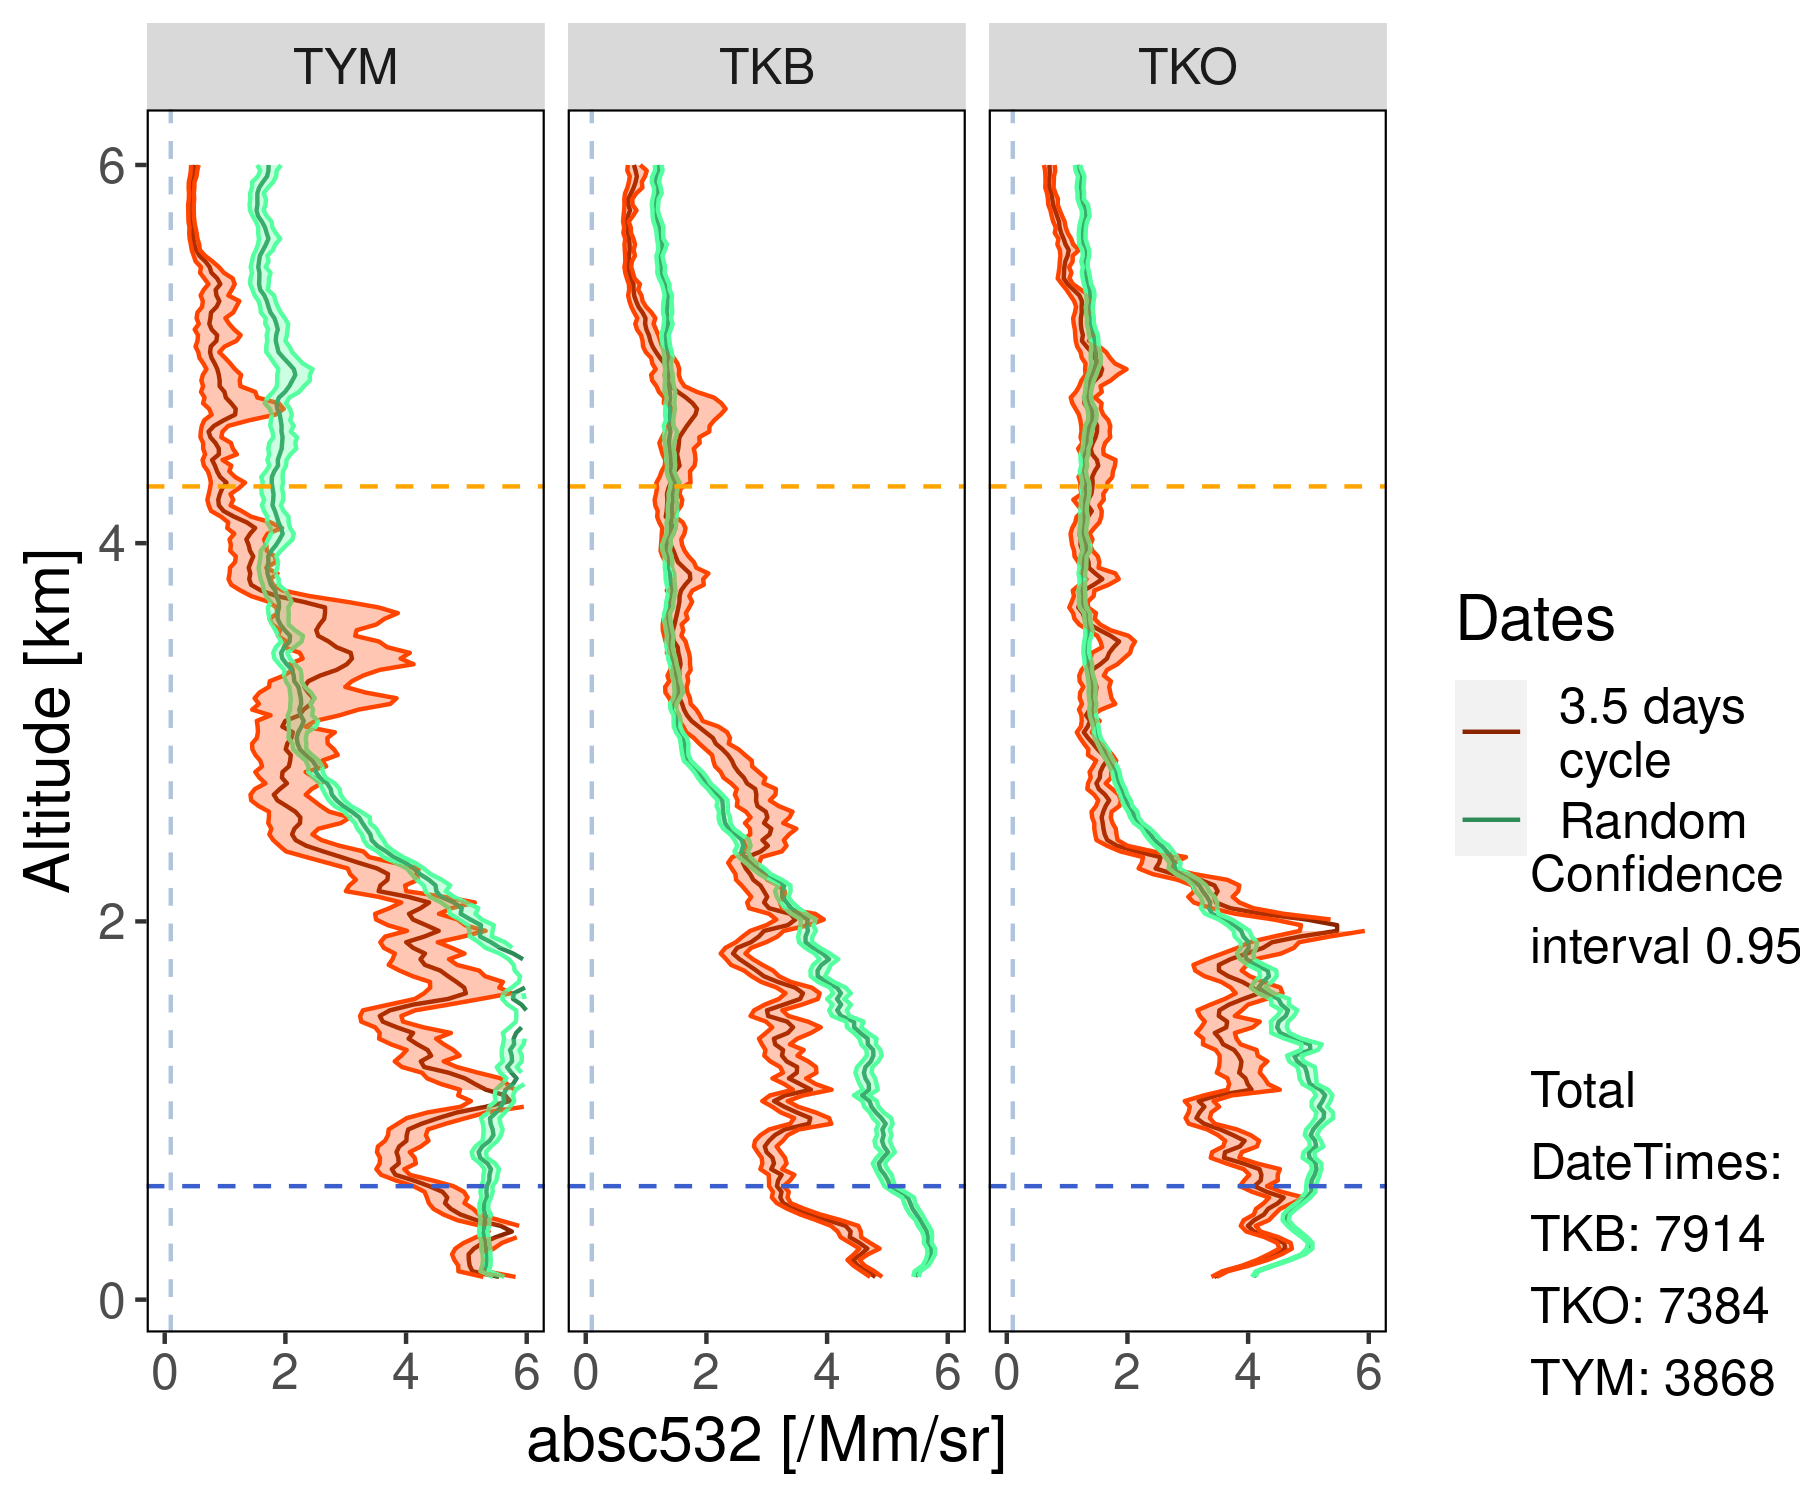

In [44]:
LidarStations_35d <- read_rds("data/LidarSatations_35d.RDS")

# Select Lidar station variables and dates with 3.5d cycle
# Empty list to fill
LidarVars_35c <- list()
LidarVars_RNG <- list()
BAE_list <- list()
absc532_listS <- list()
rngReps <- 10
# When does the cycle 3.5days reach the surface in a particle variable such as absc532?

# Function to compute the bootstrap interval:
bsci <- function(x,B){
  bstrap <- c()
  for (i in 1:B){
    bstrap <- c(bstrap,mean(sample(x,length(x),replace=T), na.rm=TRUE))
  }
  return(bstrap)
}

for (ldStat in Jap_lidar) {
  
  # Select only dates with 3.5d cycle: extract hours lagged 1 
  # day below the diagonal with correlations above 0.5 in a TW (s=84h)
  Corr_absc532_d <- tibble(Corr =  Corr_tw84_c[[ldStat]],
                           DatesH = seq(from = as.POSIXct("2010-01-01 00:00:00",tz = "UTC"),
                                       to = as.POSIXct("2016-12-31 23:00:00",tz = "UTC"),
                                       by="hour") ) %>%
                    # Select correlations over 0.5
                    filter(Corr > 0.5 )
                    #mutate(DatesH = ymd_h( format(as.POSIXct(Dates),format="%Y-%m-%d  %H")  )  ) %>%
                   
  
  LidarVars_Stat <- lapply(LidarStations_35d[[ldStat]], function(ldVar){
                      ldVar[ldVar$DatesH %in% Corr_absc532_d$DatesH,]  
                     })
  LidarVars_35c[[ldStat]] <- LidarVars_Stat
  remove(LidarVars_Stat)
  
  LidarVars_MultMtx <- list()
  
  for(ri in 1:rngReps){
    # Random Dates for comparison
    RandomDates <- seq(from = as.POSIXct("2010-01-01 00:00:00",tz = "UTC"),
                       to = as.POSIXct("2016-12-31 23:00:00",tz = "UTC"),
                       by="hour") %>%
                   sample(x=., size = length(Corr_absc532_d$DatesH), replace = FALSE)

    LidarVars_StatRNG <- lapply(LidarStations_35d[[ldStat]], function(ldVar){
                            ldVar[ldVar$DatesH %in% RandomDates,] %>%
                            select(-c("Dates","DatesH","DatesD")) %>%
                            as.matrix()
                          })
    LidarVars_MultMtx[[ri]] <- LidarVars_StatRNG
  }
  
  # Extract BAE matrices
  LidarVars_BAE <- sapply(LidarVars_MultMtx, "[", "absc532")
  # Compute the mean matrix for all random dates
  LidarVars_mean <- rowMeans(simplify2array(LidarVars_BAE), dims=2, na.rm=TRUE)
  # Store in a list per station
  LidarVars_RNG[[ldStat]] <- LidarVars_mean
  remove(LidarVars_mean)
  remove(LidarVars_MultMtx)
  
  # BAE(532/1064) height distribution list per station
  BAE_list[[ldStat]] <- tibble(
    subWeekly_Mean = LidarVars_35c[[ldStat]]$absc532 %>% 
                       select(-c(Dates, DatesH, DatesD)) %>%
                       as.matrix() %>%
                       colMeans(na.rm=TRUE),
   subWeekly_Upper = LidarVars_35c[[ldStat]]$absc532 %>% 
                      select(-c(Dates, DatesH, DatesD)) %>%
                      as.matrix() %>%
                      apply(., MARGIN = 2, FUN=function(uh){
                         output <- bsci(uh, 100)
                         upperLim <- quantile(output,.95, na.rm = TRUE)
                         return(upperLim)
                      }),
                    #colMeans(na.rm=TRUE),
   subWeekly_Lower = LidarVars_35c[[ldStat]]$absc532 %>% 
                      select(-c(Dates, DatesH, DatesD)) %>%
                      as.matrix()  %>%
                      apply(., MARGIN = 2, FUN=function(ul){
                        output <- bsci(ul, 100)
                        lowerLim <- quantile(output,.05, na.rm = TRUE)
                        return(lowerLim)
                      }),
   RNG_Mean  =  colMeans(LidarVars_RNG[[ldStat]], na.rm=TRUE),
   RNG_Upper  =  apply(LidarVars_RNG[[ldStat]], MARGIN = 2, FUN=function(uh){
                     output <- bsci(uh, 100)
                     upperLim <- quantile(output,.95, na.rm = TRUE)
                   return(upperLim)
                 }),
   RNG_Lower  =  apply(LidarVars_RNG[[ldStat]], MARGIN = 2, FUN=function(ul){
                     output <- bsci(ul, 100)
                     upperLim <- quantile(output,.05, na.rm = TRUE)
                   return(upperLim)
                 }),
   Station = rep(ldStat,197),
   Height = seq(0.12,6,length.out = 197)
)

}
# Remove memory heavy objects

remove(LidarVars_BAE)
remove(LidarVars_RNG)
remove(LidarVars_StatRNG)


# Bind lidar stations into a single dataset
BAE <- bind_rows(BAE_list,.id = "BindVar") %>% select(-c(BindVar))

# Format for ggplot input
BAE_gg <- melt(BAE, id.vars = c("Height","Station"), variable.name = "Dates") %>%
          # For absc532 and 1064
          mutate(value = value*1E06)

BAE_gg$Stationf <- factor(BAE_gg$Station, levels = c("TYM","TKB","TKO"))


# Colours for plot
my_colors <- c("seagreen1","seagreen4","seagreen1","orangered1", "orangered4", "orangered1")
names(my_colors) <- levels(factor(c(levels(BAE_gg$Dates), levels(BAE_gg$Dates))))
# Spread variables to inout geo_ribbon and shade the area between curves
BAE_gg_Area <- BAE_gg %>% spread(Dates, value)

#Plot Vertical profiles with 96% interval confidence for 
#3 lidar stations and one lidar variable
ggplot(BAE_gg, aes(Height,value)) + 
  geom_line(aes(colour=Dates )) +
  scale_color_manual(values = my_colors,
                     name  ="Dates",
                     breaks=c("subWeekly_Mean", "RNG_Mean"),
                     labels=c("3.5 days\ncycle", "Random")) +
  geom_ribbon(data=BAE_gg_Area, inherit.aes=FALSE,
              aes(x=Height,ymin=RNG_Lower, ymax=RNG_Upper), alpha=0.3, fill="seagreen1") +
  geom_ribbon(data=BAE_gg_Area, inherit.aes=FALSE,
              aes(x=Height,ymin=subWeekly_Lower,ymax=subWeekly_Upper), alpha=0.3, fill="orangered1") +
  ylab("absc532 [/Mm/sr]") +
  xlab("Altitude [km]") +
  coord_cartesian(xlim = c(0,7)) +
  #scale_y_continuous(breaks = round(seq(1,6, by = 1),1)) +
  coord_flip() +
  theme(
    text = element_text(size=15),
    panel.background = element_blank(),
    panel.border = element_rect(colour="black", fill=NA)
  ) +
  #geom_hline(yintercept=1,linetype="dashed") +
  geom_vline(xintercept=4.3,linetype="dashed",col="orange") +
  geom_vline(xintercept=0.6,linetype="dashed",col="royalblue3") +
  geom_hline(yintercept=0.1,linetype="dashed",col="lightsteelblue") +
  ylim(0,6) +
  facet_wrap(~Stationf)
# width = 800 height 700
grid.text("Confidence\ninterval 0.95\n\nTotal\nDateTimes:\nTKB: 7914\nTKO: 7384\nTYM: 3868",
          x=unit(0.85,"npc"),y=unit(0.25,"npc"),just = "left")

## Supplementary Figure 8

## Supplementary Figure 9

Installing package into ‘/home/navarral/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



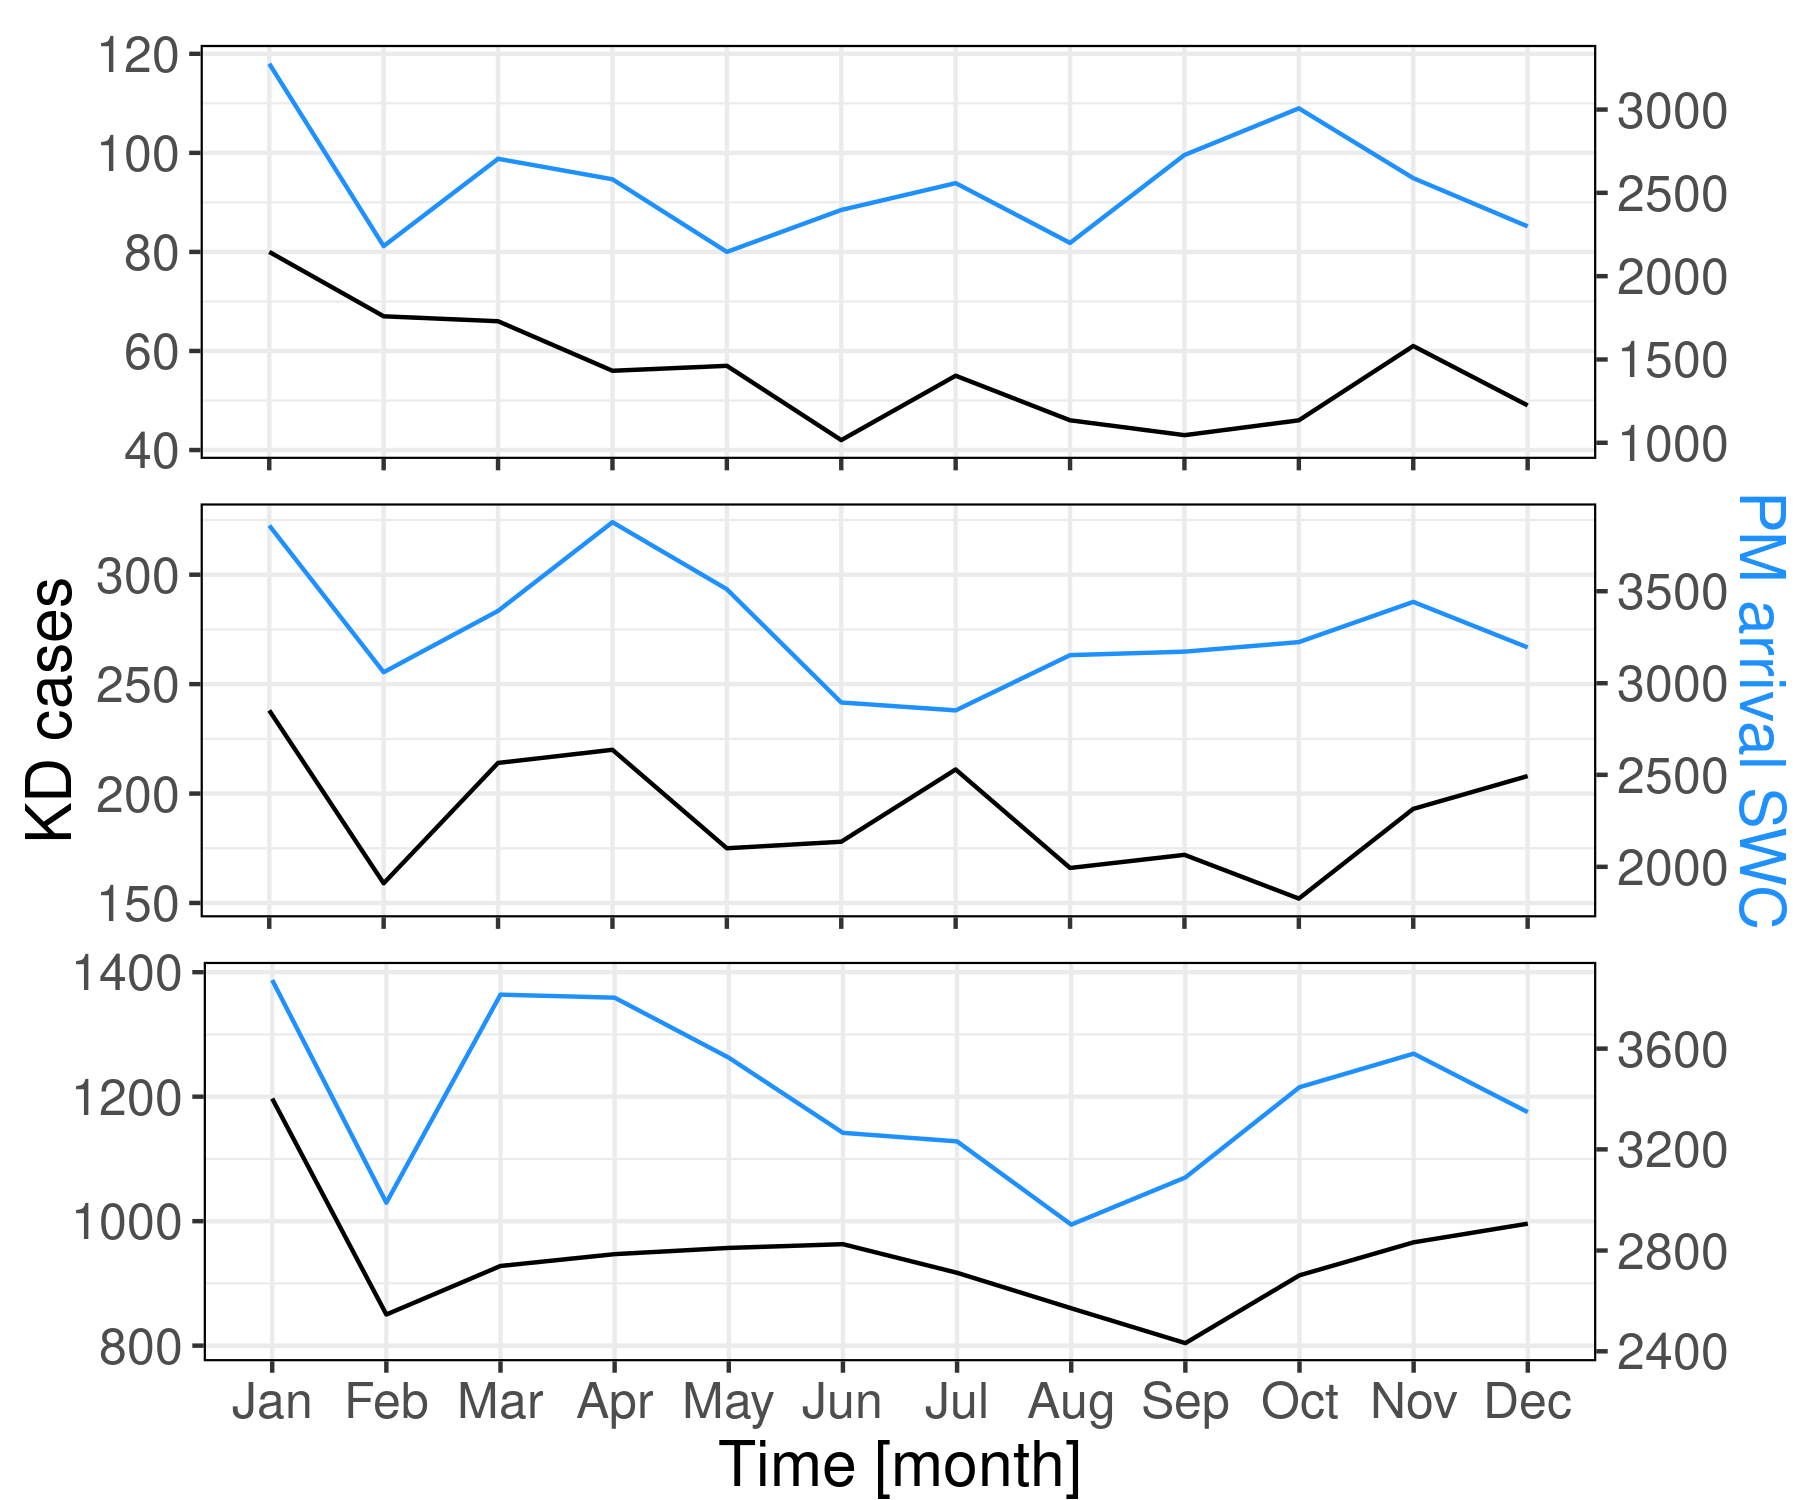

In [39]:
install.packages("ggpubr",
                 repos = c("https://cran.rediris.org/", "https://cloud.r-project.org/"),
                 dependencies = TRUE)
require("ggpubr",character.only=TRUE, quietly = TRUE)

options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res=300)

KD_file_ms <- read_csv("../data/KD_1970_2016_Albert.csv", col_types = cols(.default = "c")) %>%
              mutate(Dates=as.Date(Dates)) %>%
              rename(c("KD_TKB"="8", "KD_TKO"="13", "KD_TYM"="16")) %>%
              mutate(across(!Dates, as.numeric)) %>%
              .[.$Dates %in% seq(as.Date("2010-01-05"),as.Date("2016-12-25"),by="day"),] %>%
              mutate(Month=month(Dates, label=TRUE)) %>%
              group_by(Month) %>%
              summarize_at(vars("KD_TKB", "KD_TKO", "KD_TYM"), list(~sum(.,na.rm = TRUE))  )

Corr_tb_TKO_ms <- tibble(Dates = as.Date( names( Corr_tw84_c[["TKB"]]) ),
                         Corr_TKB =  Corr_tw84_c[["TKB"]],
                         Corr_TKO =  Corr_tw84_c[["TKO"]],
                         Corr_TYM =  Corr_tw84_c[["TYM"]],
                        ) %>%
              mutate(Month=month(Dates, label=TRUE)) %>%
              group_by(Month) %>%
              summarize_at(vars("Corr_TKB", "Corr_TKO", "Corr_TYM"), list(~sum(!is.na(.),na.rm = TRUE)) )
KD_2010_16_ms_gg <- right_join(Corr_tb_TKO_ms, KD_file_ms,by = "Month")

ms_scale <- function(a,b){ 
    ms <- (max(b,na.rm=TRUE) - min(b,na.rm=TRUE) ) / (max(a,na.rm=TRUE) - min(a,na.rm=TRUE))}
is_scale <- function(a,b){ 
    is <- min(b,na.rm=TRUE) - max(a,na.rm=TRUE)*(
        (max(b,na.rm=TRUE) - min(b,na.rm=TRUE) ) / (max(a,na.rm=TRUE) - min(a,na.rm=TRUE))
    )}

mTKO_ms <- ms_scale(a=KD_2010_16_ms_gg$KD_TKO,b=KD_2010_16_ms_gg$Corr_TKO)
iTKO_ms <- is_scale(a=KD_2010_16_ms_gg$KD_TKO,b=KD_2010_16_ms_gg$Corr_TKO) + 500 # Needs extra help to plot
TKO_gg <- ggplot(KD_2010_16_ms_gg) +
    aes(x=Month) +
    geom_line(aes(y= KD_TKO), group=1) +
    geom_line( aes(y= (Corr_TKO-iTKO_ms)/mTKO_ms, color="dodgerblue", group=1), 
              color="dodgerblue") +
    scale_y_continuous(sec.axis = sec_axis(trans=~.*mTKO_ms+ iTKO_ms, #trans_sec , #* ggCoeff_weekly,
                                           name="")) +
    theme_bw() + 
    labs(x='Time [month]',
         y='',
         title='',
         subtitle=paste('',sep='\n'),
         color='Variable') + 
    theme(plot.subtitle = element_text(color = "#605e5e", size = 9),
          plot.title = element_text(size=12),
          axis.title.y.right = element_text(color = "dodgerblue"),
          legend.position="none",
          plot.margin = margin(-40, 0, 0, 0),
          text = element_text(size=15),
            panel.background = element_blank(),
            panel.border = element_rect(colour="black", fill=NA)
          )
    
    
    

mTKB_ms <- ms_scale(a=KD_2010_16_ms_gg$KD_TKB,b=KD_2010_16_ms_gg$Corr_TKB)
iTKB_ms <- is_scale(a=KD_2010_16_ms_gg$KD_TKB,b=KD_2010_16_ms_gg$Corr_TKB) 
TKB_gg <- ggplot(KD_2010_16_ms_gg) +
    aes(x=Month) +
    geom_line(aes(y= KD_TKB), group=1) +
    geom_line( aes(y= (Corr_TKB-iTKB_ms)/mTKB_ms, color="dodgerblue", group=1), 
              color="dodgerblue") +
    scale_y_continuous(sec.axis = sec_axis(trans=~.*mTKB_ms+ iTKB_ms, #trans_sec , #* ggCoeff_weekly,
                                           name="PM arrival SWC")) +
    theme_bw() + 
    labs(x='',
         y='KD cases',
         title='',
         subtitle=paste('',sep='\n'),
         color='Variable') + 
    theme(plot.subtitle = element_text(color = "#605e5e", size = 9),
          plot.title = element_text(size=12),
          axis.title.y.right = element_text(color = "dodgerblue"),
          axis.text.x=element_blank(),
          legend.position="none",
          plot.margin = margin(-30, 0, 0, 6),
          text = element_text(size=15),
            panel.background = element_blank(),
            panel.border = element_rect(colour="black", fill=NA)
          )
    

mTYM_ms <- ms_scale(a=KD_2010_16_ms_gg$KD_TYM,b=KD_2010_16_ms_gg$Corr_TYM)
iTYM_ms <- is_scale(a=KD_2010_16_ms_gg$KD_TYM,b=KD_2010_16_ms_gg$Corr_TYM) 
TYM_gg <- ggplot(KD_2010_16_ms_gg) +
    aes(x=Month) +
    geom_line(aes(y= KD_TYM), group=1) +
    geom_line( aes(y= (Corr_TYM-iTYM_ms)/mTYM_ms, color="dodgerblue", group=1), 
              color="dodgerblue") +
    scale_y_continuous(sec.axis = sec_axis(trans=~.*mTYM_ms+ iTYM_ms, #trans_sec , #* ggCoeff_weekly,
                                           name="")) +
    theme_bw() + 
    labs(x='',
         y='',
         title='',
         subtitle=paste('',sep='\n'),
         color='Variable') + 
    theme(plot.subtitle = element_text(color = "#605e5e", size = 9),
          plot.title = element_text(size=12),
          axis.title.y.right = element_text(color = "dodgerblue"),
          axis.text.x=element_blank(),
          legend.position="none",
          plot.margin = margin(-20, 0, -10, 6),
          text = element_text(size=15),
            panel.background = element_blank(),
            panel.border = element_rect(colour="black", fill=NA)
          )
    
    

ggarrange(TYM_gg, TKB_gg, TKO_gg, 
                    #labels = c("A", "B", "C"),
                    ncol = 1, nrow = 3)
